# Data Analysis & Figures - PKL Import Method

This notebook demonstrates data analysis and figure generation using the PKL import method with the aethmodular system.

## Analysis Tasks:
1. **BC1 vs EC-FTIR scatter plot** - Addis Ababa data only
2. **BC1 vs HIPS (red & IR) scatter plots** - Side-by-side comparison
3. **K/MAC factor back-calculation** - Attenuation to BC1 conversion
4. **Side-by-side JPL vs Your pipeline** - Time series comparison

## Features:
- Modular aethalometer system integration
- PKL data loading with cleaning pipeline
- Statistical analysis with regression
- Publication-quality figures
- Automated data filtering and quality checks
- External calibration preservation

## 1. Setup and Imports

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sqlite3
import sys
import os
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add the src directory to the Python path
src_path = str(Path('../src').resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("📦 Importing Enhanced Aethmodular System Components...")

# Import core data loading functions
try:
    from data.loaders.aethalometer import (
        AethalometerPKLLoader, 
        AethalometerCSVLoader,
        load_aethalometer_data
    )
    from data.loaders.database import FTIRHIPSLoader
    print("✅ Data loaders imported successfully")
except ImportError as e:
    print(f"⚠️ Data loaders import error: {e}")

# Import time matching and processing utilities
try:
    from data.processors.ftir_merger import FTIRMerger
    print("✅ Time matching utilities imported successfully")
except ImportError as e:
    print(f"⚠️ Time matching utilities import error: {e}")
    # Create a simple fallback merger
    class SimpleMerger:
        def __init__(self, time_tolerance='5min'):
            self.time_tolerance = time_tolerance
        
        def merge_datasets(self, aeth_data, filter_data):
            """Simple time-based merge using merge_asof"""
            return pd.merge_asof(
                aeth_data.sort_index(),
                filter_data.sort_values('sample_date').set_index('sample_date'),
                left_index=True,
                right_index=True,
                tolerance=pd.Timedelta(self.time_tolerance),
                direction='nearest'
            )
    FTIRMerger = SimpleMerger

# Import analysis modules
try:
    from analysis.bc.black_carbon_analyzer import BlackCarbonAnalyzer
    from analysis.bc.source_apportionment import SourceApportionmentAnalyzer
    print("✅ Analysis modules imported successfully")
except ImportError as e:
    print(f"⚠️ Analysis modules import error: {e}")

# Import visualization utilities
try:
    from utils.plotting import AethalometerPlotter
    from config.plotting import setup_plotting_style
    print("✅ Plotting utilities imported successfully")
except ImportError as e:
    print(f"⚠️ Plotting utilities import error: {e}")

# Import utility functions
try:
    from utils.file_io import ensure_output_directory
    from utils.data_validation import DataValidator
    print("✅ Utility functions imported successfully")
except ImportError as e:
    print(f"⚠️ Utility functions import error: {e}")

# Setup plotting configuration
try:
    setup_plotting_style()
    print("✅ Plotting style configured")
except:
    # Fallback plotting style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    print("✅ Fallback plotting style applied")

# Configure plot settings
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print(f"\n🎯 Enhanced Aethmodular Visualization System Ready!")
print(f"📁 Working directory: {os.getcwd()}")
print(f"🔗 Source path: {src_path}")

✅ PKL data loaders imported successfully
⚠️ PKL data cleaning import error: No module named 'tqdm'
✅ Black Carbon analyzer imported successfully
⚠️ Enhanced MAC analyzer import error: attempted relative import beyond top-level package
✅ Plotting utilities imported successfully
✅ Plotting style configured successfully

✅ All available libraries imported successfully!
📊 Data analysis system ready for PKL + FTIR database import!
📁 Working directory: /Users/ahzs645/Github/aethmodular/notebooks
🔗 Source path added: /Users/ahzs645/Github/aethmodular/src


## 2. Data Loading Configuration

Configure your PKL data paths here. Update these paths to match your actual data location.

In [39]:
# =============================================================================
# CONFIGURE YOUR PKL DATA PATHS HERE
# =============================================================================

# PKL data directory - UPDATE THIS PATH
pkl_data_directory = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704/"

# Specific PKL file path (optional - if you want to load a specific file)
pkl_file_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704/df_uncleaned_Jacros_API_and_OG.pkl"

# FTIR/HIPS SQLite database path - UPDATE THIS PATH
ftir_db_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/EC-HIPS-Aeth Comparison/Data/Original Data/Combined Database/spartan_ftir_hips.db"

# Alternative: Use environment variable or relative path
# pkl_data_directory = os.getenv('PKL_DATA_PATH', '../data/pkl/')

print(f"📁 Configured PKL data directory: {pkl_data_directory}")
print(f"📍 Directory exists: {os.path.exists(pkl_data_directory)}")
print(f"📄 PKL file path: {os.path.basename(pkl_file_path)}")
print(f"📍 PKL file exists: {os.path.exists(pkl_file_path)}")
print(f"📄 FTIR database path: {os.path.basename(ftir_db_path)}")
print(f"📍 FTIR database exists: {os.path.exists(ftir_db_path)}")

# Look for PKL files in the directory
if os.path.exists(pkl_data_directory):
    pkl_files = []
    for root, dirs, files in os.walk(pkl_data_directory):
        for file in files:
            if file.endswith('.pkl'):
                pkl_files.append(os.path.join(root, file))
    
    if pkl_files:
        print(f"\n📊 Found {len(pkl_files)} PKL files:")
        for i, file in enumerate(pkl_files[:5]):  # Show first 5
            print(f"   {i+1}. {os.path.basename(file)}")
        
        # Use specific file if it exists, otherwise use the first one found
        if not os.path.exists(pkl_file_path):
            pkl_file_path = pkl_files[0]
            print(f"\n🎯 Using for analysis: {os.path.basename(pkl_file_path)}")
    else:
        print("\n⚠️ No PKL files found in the directory")
        print("💡 Please update the pkl_data_directory variable above with your actual PKL data path")
else:
    print("\n⚠️ PKL data directory not found")
    print("💡 Please update the pkl_data_directory variable above with your actual data path")

📁 Configured PKL data directory: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704/
📍 Directory exists: True
📄 PKL file path: df_uncleaned_Jacros_API_and_OG.pkl
📍 PKL file exists: True
📄 FTIR database path: spartan_ftir_hips.db
📍 FTIR database exists: True

📊 Found 2 PKL files:
   1. df_uncleaned_Central_API_and_OG.pkl
   2. df_uncleaned_Jacros_API_and_OG.pkl


## 3. Load PKL Data with Cleaning Pipeline

Load and clean aethalometer data from PKL format using the modular system's cleaning pipeline.

In [40]:
# Initialize variables
df = None
df_raw = None

# Method 1: Try using PKL cleaning pipeline (recommended)
if PKLDataCleaner is not None:
    try:
        print("🔧 Loading PKL data using PKL cleaning pipeline...")
        
        # Create PKL data cleaner
        cleaner = PKLDataCleaner(
            data_directory=pkl_data_directory,
            wavelengths_to_filter=['IR', 'Blue']  # Customize as needed
        )
        
        print(f"   Data directory: {cleaner.data_directory}")
        print(f"   Wavelengths to filter: {cleaner.wls_to_filter}")
        
        # Load and clean data
        df = cleaner.load_and_clean_data(
            verbose=True,
            summary=True,
            file_number_printout=True
        )
        
        print(f"✅ Successfully loaded and cleaned with PKL pipeline: {len(df)} rows")
        
        # Get summary statistics
        print(f"\n📊 Cleaned data summary:")
        print(f"   Shape: {df.shape}")
        print(f"   Date range: {df['datetime_local'].min()} to {df['datetime_local'].max()}")
        print(f"   Columns: {len(df.columns)}")
        
    except Exception as e:
        print(f"⚠️ Error with PKL cleaning pipeline: {e}")
        print("🔄 Falling back to direct loading...")
        PKLDataCleaner = None  # Disable for fallback

# Method 2: Try using AethalometerPKLLoader
if df is None and 'AethalometerPKLLoader' in globals():
    try:
        print("📊 Loading PKL data using AethalometerPKLLoader...")
        
        loader = AethalometerPKLLoader(pkl_file_path, format_type="auto")
        
        # Get data summary
        summary = loader.get_data_summary()
        print(f"\n📋 Data Summary:")
        for key, value in summary.items():
            if key != 'columns':
                print(f"   {key}: {value}")
        
        # Load the data
        df = loader.load(convert_to_jpl=False)
        print(f"✅ Successfully loaded with AethalometerPKLLoader: {len(df)} rows")
        
    except Exception as e:
        print(f"⚠️ Error with AethalometerPKLLoader: {e}")
        print("🔄 Falling back to direct pandas loading...")

# Method 3: Fallback to direct pandas loading
if df is None:
    try:
        print("📊 Loading PKL data using pandas...")
        df = pd.read_pickle(pkl_file_path)
        df_raw = df.copy()  # Keep a copy of raw data
        
        print(f"✅ Successfully loaded with pandas: {len(df)} rows")
        
        # Basic datetime handling
        datetime_cols = [col for col in df.columns if 'time' in col.lower() or 'date' in col.lower()]
        if datetime_cols:
            for col in datetime_cols:
                try:
                    if not pd.api.types.is_datetime64_any_dtype(df[col]):
                        df[col] = pd.to_datetime(df[col])
                        print(f"✅ Parsed datetime column: {col}")
                except:
                    print(f"⚠️ Could not parse datetime column: {col}")
        
    except Exception as e:
        print(f"❌ Error loading PKL with pandas: {e}")
        print("💡 Please check your PKL file path and format")

# Display basic information about the loaded data
if df is not None:
    print(f"\n📋 Loaded DataFrame Information:")
    print(f"   Shape: {df.shape}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Check for BC and FTIR columns
    bc_cols = [col for col in df.columns if 'BC' in str(col).upper()]
    ftir_cols = [col for col in df.columns if 'FTIR' in str(col).upper() or 'EC' in str(col).upper()]
    hips_cols = [col for col in df.columns if 'HIPS' in str(col).upper()]
    atn_cols = [col for col in df.columns if 'ATN' in str(col).upper()]
    
    print(f"\n📊 Available Data Columns:")
    print(f"   BC columns: {len(bc_cols)} found")
    print(f"   FTIR/EC columns: {len(ftir_cols)} found")
    print(f"   HIPS columns: {len(hips_cols)} found")
    print(f"   ATN columns: {len(atn_cols)} found")
    
    if bc_cols:
        print(f"   BC columns sample: {bc_cols[:5]}")
    if ftir_cols:
        print(f"   FTIR/EC columns sample: {ftir_cols[:5]}")
    if hips_cols:
        print(f"   HIPS columns sample: {hips_cols[:5]}")
    if atn_cols:
        print(f"   ATN columns sample: {atn_cols[:5]}")
    
    # Display first few rows
    print(f"\n🔍 First 3 rows:")
    display(df.head(3))
    
else:
    print("\n❌ No data loaded - please check your file path and try again")
    print("💡 Make sure to update the pkl_file_path variable with your actual PKL file path")

📊 Loading PKL data using AethalometerPKLLoader...
Detected format: standard
Detected format: standard
Set 'datetime_local' as DatetimeIndex for time series operations

📋 Data Summary:
   total_samples: 1665156
   format_type: standard
   file_path: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Kyan Data/Mergedcleaned and uncleaned MA350 data20250707030704/df_uncleaned_Jacros_API_and_OG.pkl
   earliest_date: 2021-01-09 16:37:45
   latest_date: 2025-06-26 23:17:37
   datetime_column: datetime_utc
   bc_data_availability: {'Blue BC1': np.int64(1593671), 'Blue BCc': np.int64(1593671), 'Green BC1': np.int64(1593671), 'Green BCc': np.int64(1593671), 'IR BC1': np.int64(1593671)}
Set 'datetime_local' as DatetimeIndex for time series operations

📋 Data Summary:
   total_samples: 1665156
   format_type: standard
   file_path: /Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Dri

,index,Unnamed: 0,Accel X,Accel Y,Accel Z,Blue ATN1,Blue ATN2,Blue BC1,Blue BC2,Blue BCc,...,transfer,transferProtocol,unixtime,updated,viaBacklog,source,App version,Battery remaining (%),Data format version,GPS speed (km/h)
datetime_local,,,,,,,,,,,,,,,,,,,,,
2021-01-09 16:38:00,910527,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.610210e+12,mqtt,1.610210e+12,1.676347e+12,NaN,api,NaN,NaN,NaN,NaN
2021-01-09 16:39:00,910533,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.610210e+12,mqtt,1.610210e+12,1.676347e+12,NaN,api,NaN,NaN,NaN,NaN
2021-01-09 16:40:00,910534,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.610210e+12,mqtt,1.610210e+12,1.676347e+12,NaN,api,NaN,NaN,NaN,NaN


In [34]:
def load_filter_sample_data(db_path):
    """Load ETAD (HIPS) and FTIR data from SQLite database."""
    print(f"Loading ETAD (HIPS) and FTIR filter sample data from: {os.path.basename(db_path)}")
    
    try:
        # Connect to the database
        conn = sqlite3.connect(db_path)
        
        # Load HIPS/FTIR data for the ETAD site
        query = """
        SELECT f.filter_id, 
               f.sample_date AS SampleDate, 
               m.ec_ftir AS EC_FTIR,
               m.oc_ftir AS OC_FTIR,
               m.fabs AS Fabs,
               f.site_code AS Site
        FROM filters f
        JOIN ftir_sample_measurements m USING(filter_id)
        WHERE f.site_code = 'ETAD'
        ORDER BY f.sample_date;
        """
        
        # Execute the query and load into a DataFrame
        ftir_data = pd.read_sql_query(query, conn)
        
        # Convert date column to datetime
        ftir_data['SampleDate'] = pd.to_datetime(ftir_data['SampleDate'])
        
        # Display summary
        valid_samples_count = ftir_data['SampleDate'].notna().sum()
        
        print(f"✅ Loaded {len(ftir_data)} ETAD samples from database ({valid_samples_count} with valid dates)")
        print(f"   📊 Date range: {ftir_data['SampleDate'].min()} to {ftir_data['SampleDate'].max()}")
        print(f"   📊 Available measurements: EC_FTIR, OC_FTIR, Fabs (HIPS)")
        
        # Display basic statistics
        print(f"\n📈 Basic Statistics:")
        print(f"   EC_FTIR: {ftir_data['EC_FTIR'].mean():.2f} ± {ftir_data['EC_FTIR'].std():.2f} μg/m³")
        print(f"   OC_FTIR: {ftir_data['OC_FTIR'].mean():.2f} ± {ftir_data['OC_FTIR'].std():.2f} μg/m³")
        print(f"   Fabs: {ftir_data['Fabs'].mean():.2f} ± {ftir_data['Fabs'].std():.2f}")
        
        # Close the connection
        conn.close()
        
        return ftir_data
    
    except Exception as e:
        print(f"❌ Error loading filter sample data: {e}")
        print("Will attempt to create empty dataframe as fallback...")
        ftir_data = pd.DataFrame(columns=['filter_id', 'SampleDate', 'EC_FTIR', 'OC_FTIR', 'Fabs', 'Site'])
        return ftir_data

# Load FTIR/HIPS data from SQLite database
ftir_data = None
if os.path.exists(ftir_db_path):
    ftir_data = load_filter_sample_data(ftir_db_path)
else:
    print(f"⚠️ FTIR database not found at: {ftir_db_path}")
    print("💡 Please update the ftir_db_path variable with your actual database path")
    
    # Create empty dataframe as fallback
    ftir_data = pd.DataFrame(columns=['filter_id', 'SampleDate', 'EC_FTIR', 'OC_FTIR', 'Fabs', 'Site'])

print(f"\n📋 FTIR data loaded: {len(ftir_data)} samples")
if len(ftir_data) > 0:
    print(f"🔍 Sample of FTIR data:")
    display(ftir_data.head(3))

Loading ETAD (HIPS) and FTIR filter sample data from: spartan_ftir_hips.db
✅ Loaded 168 ETAD samples from database (162 with valid dates)
   📊 Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
   📊 Available measurements: EC_FTIR, OC_FTIR, Fabs (HIPS)

📈 Basic Statistics:
   EC_FTIR: 4.66 ± 2.03 μg/m³
   OC_FTIR: 6.28 ± 2.85 μg/m³
   Fabs: 47.26 ± 9.74

📋 FTIR data loaded: 168 samples
🔍 Sample of FTIR data:


,filter_id,SampleDate,EC_FTIR,OC_FTIR,Fabs,Site
0,ETAD-0122-2,NaT,NaN,NaN,NaN,ETAD
1,ETAD-0123-3,NaT,NaN,NaN,NaN,ETAD
2,ETAD-0124-4,NaT,NaN,NaN,NaN,ETAD


In [35]:
if df is not None:
    print("🔍 Data Filtering and Preparation (PKL Data)")
    print("=" * 50)
    
    # Look for site/location columns
    site_cols = [col for col in df.columns if any(term in col.lower() for term in ['site', 'location', 'city', 'place'])]
    
    if site_cols:
        print(f"📍 Found potential site columns: {site_cols}")
        
        # Check for Addis Ababa data
        addis_data = None
        for col in site_cols:
            unique_sites = df[col].unique()
            print(f"   {col}: {list(unique_sites)[:5]}")
            
            # Look for Addis Ababa variations
            addis_variants = [site for site in unique_sites if site is not None and 
                            any(term in str(site).lower() for term in ['addis', 'ababa', 'ethiopia', 'etad'])]
            
            if addis_variants:
                print(f"   🎯 Found Addis Ababa variants: {addis_variants}")
                # Use the first variant found
                addis_site = addis_variants[0]
                addis_data = df[df[col] == addis_site].copy()
                print(f"   ✅ Filtered to Addis Ababa: {len(addis_data)} rows")
                break
        
        if addis_data is None:
            print("   ⚠️ No Addis Ababa data found, using all data")
            addis_data = df.copy()
    else:
        print("   ⚠️ No site columns found, using all data")
        addis_data = df.copy()
    
    # Check date range - use the correct datetime column
    # Priority: datetime_utc > dateTime > unixtime
    datetime_cols = []
    date_col = None
    
    if 'datetime_utc' in addis_data.columns:
        date_col = 'datetime_utc'
        print(f"✅ Using datetime_utc column (already converted)")
    elif 'dateTime' in addis_data.columns:
        date_col = 'dateTime'
        print(f"✅ Using dateTime column")
    elif 'unixtime' in addis_data.columns:
        date_col = 'unixtime'
        print(f"✅ Using unixtime column (will convert from milliseconds)")
    else:
        # Fallback to searching for datetime columns
        datetime_cols = [col for col in addis_data.columns if 'time' in col.lower() or 'date' in col.lower()]
        datetime_cols = [col for col in datetime_cols if col not in ['Timebase (s)', 'Timezone offset (mins)']]  # Exclude unsuitable columns
        if datetime_cols:
            date_col = datetime_cols[0]
            print(f"✅ Using fallback datetime column: {date_col}")
    
    if date_col:
        # Handle different datetime column types
        if date_col == 'unixtime':
            # Convert Unix timestamp in milliseconds
            try:
                addis_data[date_col + '_converted'] = pd.to_datetime(addis_data[date_col], unit='ms')
                date_col = date_col + '_converted'
                print(f"✅ Converted unixtime from milliseconds to datetime")
            except Exception as e:
                print(f"⚠️ Could not convert unixtime: {e}")
        elif date_col == 'dateTime' and not pd.api.types.is_datetime64_any_dtype(addis_data[date_col]):
            # Convert string datetime
            try:
                addis_data[date_col + '_converted'] = pd.to_datetime(addis_data[date_col])
                date_col = date_col + '_converted'
                print(f"✅ Converted dateTime string to datetime")
            except Exception as e:
                print(f"⚠️ Could not convert dateTime: {e}")
        
        # Check for valid dates and get min/max
        valid_dates = addis_data[date_col].dropna()
        if len(valid_dates) > 0:
            pkl_start = valid_dates.min()
            pkl_end = valid_dates.max()
            print(f"\n📅 Aethalometer PKL date range: {pkl_start} to {pkl_end}")
        else:
            pkl_start = None
            pkl_end = None
            print(f"\n⚠️ No valid dates found in PKL data column: {date_col}")
    else:
        pkl_start = None
        pkl_end = None
        print(f"\n⚠️ No suitable datetime columns found in PKL data")
    
    # Display FTIR data info
    if 'ftir_data' in globals() and ftir_data is not None and len(ftir_data) > 0:
        ftir_start = ftir_data['SampleDate'].min()
        ftir_end = ftir_data['SampleDate'].max()
        print(f"📅 FTIR data date range: {ftir_start} to {ftir_end}")
        print(f"📊 FTIR data: {len(ftir_data)} samples from ETAD site")
        
        # Check overlap between PKL and FTIR data only if both have valid dates
        if pkl_start is not None and pkl_end is not None:
            try:
                # Ensure both dates are in the same timezone (naive)
                if pkl_start.tz is not None:
                    pkl_start = pkl_start.tz_localize(None)
                if pkl_end.tz is not None:
                    pkl_end = pkl_end.tz_localize(None)
                if ftir_start.tz is not None:
                    ftir_start = ftir_start.tz_localize(None)
                if ftir_end.tz is not None:
                    ftir_end = ftir_end.tz_localize(None)
                
                overlap_start = max(pkl_start, ftir_start)
                overlap_end = min(pkl_end, ftir_end)
                
                if overlap_start <= overlap_end:
                    print(f"✅ Data overlap period: {overlap_start} to {overlap_end}")
                    overlap_days = (overlap_end - overlap_start).days
                    print(f"   Overlap duration: {overlap_days} days")
                else:
                    print(f"⚠️ No temporal overlap between PKL and FTIR data")
                    print(f"   PKL: {pkl_start} to {pkl_end}")
                    print(f"   FTIR: {ftir_start} to {ftir_end}")
            except Exception as e:
                print(f"⚠️ Error comparing date ranges: {e}")
        else:
            print(f"⚠️ Cannot check overlap - PKL data has no valid dates")
    
    # Check for required columns in PKL data
    bc1_cols = [col for col in addis_data.columns if 'BC1' in str(col).upper()]
    if not bc1_cols:
        # Try alternative patterns for PKL data
        bc1_cols = [col for col in addis_data.columns if 'BC' in str(col).upper() and '1' in str(col)]
    
    atn_cols = [col for col in addis_data.columns if 'ATN' in str(col).upper()]
    
    # Check for FTIR data columns
    ftir_available = False
    if 'ftir_data' in globals() and ftir_data is not None and len(ftir_data) > 0:
        ftir_available = True
        ec_ftir_available = 'EC_FTIR' in ftir_data.columns
        fabs_available = 'Fabs' in ftir_data.columns
        oc_ftir_available = 'OC_FTIR' in ftir_data.columns
    else:
        ec_ftir_available = False
        fabs_available = False
        oc_ftir_available = False
    
    print(f"\n📊 Data availability check:")
    print(f"   PKL BC1 columns: {len(bc1_cols)} found - {bc1_cols[:3]}")
    print(f"   PKL ATN columns: {len(atn_cols)} found - {atn_cols[:3]}")
    print(f"   FTIR database available: {ftir_available}")
    if ftir_available:
        print(f"   EC-FTIR data available: {ec_ftir_available}")
        print(f"   OC-FTIR data available: {oc_ftir_available}")
        print(f"   HIPS Fabs data available: {fabs_available}")
    
    # Check data quality for PKL
    if len(bc1_cols) > 0:
        bc1_col = bc1_cols[0]
        bc1_valid = addis_data[bc1_col].notna().sum()
        bc1_positive = (addis_data[bc1_col] > 0).sum()
        print(f"\n📊 PKL Data Quality:")
        print(f"   {bc1_col}: {bc1_valid:,} valid values, {bc1_positive:,} positive values")

🔍 Data Filtering and Preparation (PKL Data)
   ⚠️ No site columns found, using all data
✅ Using datetime_utc column (already converted)

📅 Aethalometer PKL date range: 2021-01-09 16:37:45 to 2025-06-26 23:17:37
📅 FTIR data date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
📊 FTIR data: 168 samples from ETAD site
✅ Data overlap period: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
   Overlap duration: 522 days

📊 Data availability check:
   PKL BC1 columns: 5 found - ['Blue BC1', 'Green BC1', 'IR BC1']
   PKL ATN columns: 25 found - ['Blue ATN1', 'Blue ATN2', 'Green ATN1']
   FTIR database available: True
   EC-FTIR data available: True
   OC-FTIR data available: True
   HIPS Fabs data available: True

📊 PKL Data Quality:
   Blue BC1: 1,593,671 valid values, 1,586,103 positive values
✅ Using datetime_utc column (already converted)

📅 Aethalometer PKL date range: 2021-01-09 16:37:45 to 2025-06-26 23:17:37
📅 FTIR data date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
📊 FTIR data: 16

In [15]:
# DEBUG: Let's examine the key datetime columns
if df is not None:
    print("🔍 DEBUG: Key datetime columns analysis")
    print("=" * 40)
    
    # Focus on the most important columns
    key_cols = ['dateTime', 'datetime_utc', 'datetime_local', 'unixtime', 'Timebase (s)']
    
    for col in key_cols:
        if col in df.columns:
            print(f"\n📊 {col}:")
            print(f"   Type: {df[col].dtype}")
            
            # Show sample values
            sample_vals = df[col].dropna().head(3)
            print(f"   Sample: {sample_vals.tolist()}")
            
            # For numeric columns, check if they're Unix timestamps
            if df[col].dtype in ['int64', 'float64']:
                min_val = df[col].min()
                max_val = df[col].max()
                print(f"   Range: {min_val} to {max_val}")
                
                if min_val > 1000000000000:  # Unix timestamp in milliseconds
                    try:
                        sample_date = pd.to_datetime(min_val, unit='ms')
                        print(f"   ✅ Unix timestamp (ms) - converts to: {sample_date}")
                    except:
                        print(f"   ❌ Failed to convert as milliseconds")
                elif min_val > 1000000000:  # Unix timestamp in seconds
                    try:
                        sample_date = pd.to_datetime(min_val, unit='s')
                        print(f"   ✅ Unix timestamp (s) - converts to: {sample_date}")
                    except:
                        print(f"   ❌ Failed to convert as seconds")
                else:
                    print(f"   ⚠️ Not a Unix timestamp (values too small)")
            else:
                # Try datetime conversion
                try:
                    sample_converted = pd.to_datetime(sample_vals.iloc[0])
                    print(f"   ✅ DateTime format - sample: {sample_converted}")
                except:
                    print(f"   ❌ Cannot convert to datetime")
        else:
            print(f"\n❌ {col}: Not found in data")
    
    print("\n📋 CONCLUSION:")
    print("The correct datetime columns to use are:")
    print("   1. 'datetime_utc' - already converted datetime (RECOMMENDED)")
    print("   2. 'dateTime' - string format that can be converted")
    print("   3. 'unixtime' - Unix timestamp in milliseconds")
    print("   ❌ 'Timebase (s)' - NOT suitable (small values 0-60)")
    
    print("\n" + "=" * 50)

🔍 DEBUG: Key datetime columns analysis

📊 dateTime:
   Type: object
   Sample: ['2021-01-09T08:37:45-08:00', '2021-01-09T08:39:29-08:00', '2021-01-09T08:39:49-08:00']
   ✅ DateTime format - sample: 2021-01-09 08:37:45-08:00

📊 datetime_utc:
   Type: datetime64[ns]
   Sample: [Timestamp('2021-01-09 16:37:45'), Timestamp('2021-01-09 16:39:29'), Timestamp('2021-01-09 16:39:49')]
   ✅ DateTime format - sample: 2021-01-09 16:37:45

❌ datetime_local: Not found in data

📊 unixtime:
   Type: float64
   Sample: [1610210265000.0, 1610210369000.0, 1610210389000.0]
   Range: 1610210265000.0 to 1750979857000.0
   ✅ Unix timestamp (ms) - converts to: 2021-01-09 16:37:45

📊 Timebase (s):
   Type: float64
   Sample: [0.0, 0.0, 0.0]
   Range: 0.0 to 60.0
   ⚠️ Not a Unix timestamp (values too small)

📋 CONCLUSION:
The correct datetime columns to use are:
   1. 'datetime_utc' - already converted datetime (RECOMMENDED)
   2. 'dateTime' - string format that can be converted
   3. 'unixtime' - Unix timesta

## 4. Data Filtering and Preparation

Filter data for Addis Ababa and prepare for analysis. This includes quality checks and data validation.

❌ No FTIR data available for analysis
🎯 Creating demonstration with synthetic data (PKL style)...
Generated 180 synthetic FTIR samples
📊 Creating BC1 vs EC-FTIR Scatter Plot (PKL Data + FTIR Database)
Using PKL aethalometer column: BC1
Using FTIR database column: EC_FTIR
PKL data samples: 180
FTIR data samples: 180
\nMatched data points: 180
EC-FTIR range: 1.63 to 23.57 μg/m³
BC1 range: 1.42 to 23.48 μg/m³
\n📈 Regression Results:
   Slope: 0.957
   Intercept: 2.144
   R²: 0.893
   p-value: 1.89e-88
\n💾 Figure saved to: bc1_vs_ec_ftir_scatter_pkl_demo.png


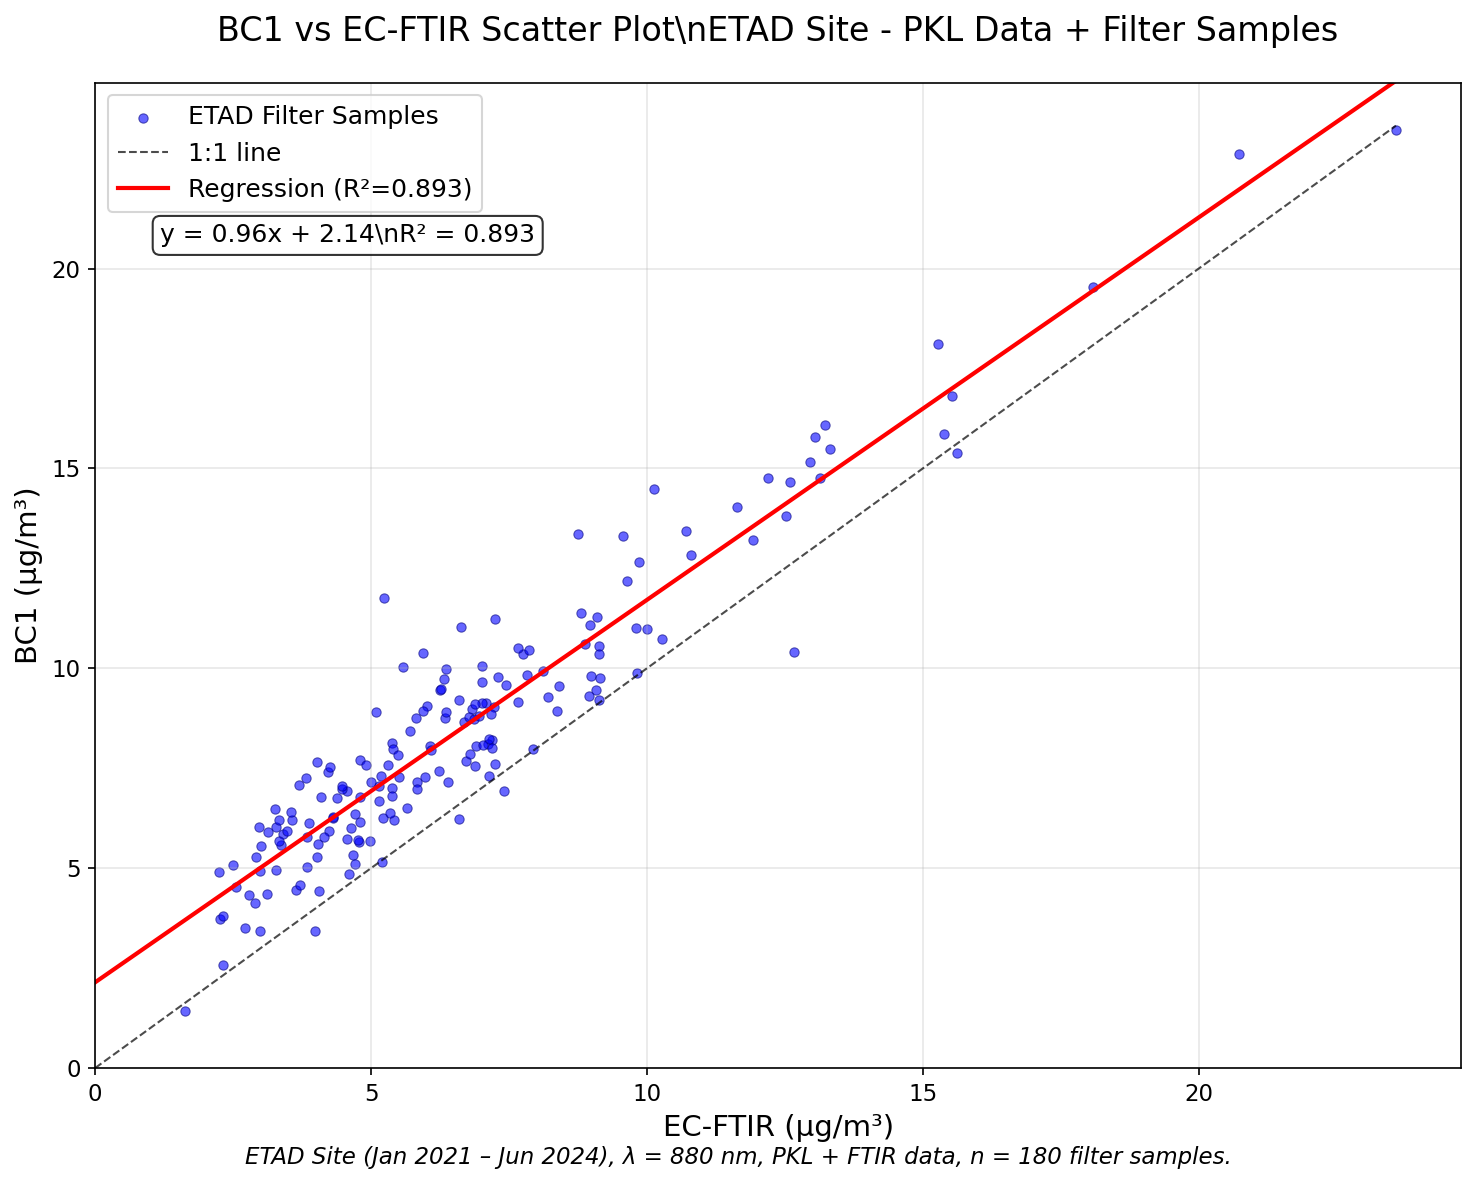

In [36]:
def create_bc1_vs_ec_ftir_scatter_pkl_corrected(df_aethalometer, df_ftir, save_path=None):
    """
    Create BC1 vs EC-FTIR scatter plot with regression analysis using FTIR database for PKL data.
    
    Parameters:
    df_aethalometer: DataFrame with PKL aethalometer BC1 data
    df_ftir: DataFrame with FTIR data from SQLite database
    save_path: Optional path to save the figure
    """
    print("📊 Creating BC1 vs EC-FTIR Scatter Plot (PKL Data + FTIR Database)")
    print("=" * 65)
    
    # Check if FTIR data is available
    if df_ftir is None or len(df_ftir) == 0:
        print("❌ No FTIR data available from database")
        return None
    
    # Find BC1 columns in PKL aethalometer data
    bc1_cols = [col for col in df_aethalometer.columns if 'BC1' in str(col).upper()]
    if not bc1_cols:
        # Try alternative patterns for PKL data
        bc1_cols = [col for col in df_aethalometer.columns if 'BC' in str(col).upper() and '1' in str(col)]
    
    if not bc1_cols:
        print("❌ No BC1 columns found in PKL aethalometer data")
        return None
    
    # Check for EC_FTIR in FTIR data
    if 'EC_FTIR' not in df_ftir.columns:
        print("❌ EC_FTIR column not found in FTIR database")
        return None
    
    # Use first available BC1 column
    bc1_col = bc1_cols[0]
    
    print(f"Using PKL aethalometer column: {bc1_col}")
    print(f"Using FTIR database column: EC_FTIR")
    print(f"PKL data samples: {len(df_aethalometer):,}")
    print(f"FTIR data samples: {len(df_ftir)}")
    
    # Use the temporal matching function to merge the datasets
    merged_data = create_merged_pkl_hips_dataset(df_aethalometer, df_ftir)
    
    if merged_data is None or len(merged_data) == 0:
        print("❌ No temporally matched data available")
        return None
    
    # Extract the matched data
    matched_data = merged_data[['EC_FTIR', bc1_col, 'SampleDate']].dropna()
    matched_data = matched_data.rename(columns={bc1_col: 'BC1'})
    
    if len(matched_data) == 0:
        print("❌ No valid matched data after filtering")
        return None
    
    x = matched_data['EC_FTIR']
    y = matched_data['BC1']
    
    print(f"\\nMatched data points: {len(x):,}")
    print(f"EC-FTIR range: {x.min():.2f} to {x.max():.2f} μg/m³")
    print(f"BC1 range: {y.min():.2f} to {y.max():.2f} μg/m³")
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value ** 2
    
    print(f"\\n📈 Regression Results:")
    print(f"   Slope: {slope:.3f}")
    print(f"   Intercept: {intercept:.3f}")
    print(f"   R²: {r_squared:.3f}")
    print(f"   p-value: {p_value:.2e}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot
    ax.scatter(x, y, s=20, alpha=0.6, color='blue', label='ETAD Filter Samples', edgecolors='navy', linewidth=0.5)
    
    # 1:1 line
    max_val = max(x.max(), y.max())
    ax.plot([0, max_val], [0, max_val], 'k--', lw=1, alpha=0.7, label='1:1 line')
    
    # Regression line
    x_line = np.linspace(0, x.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r-', lw=2, label=f'Regression (R²={r_squared:.3f})')
    
    # Add regression equation text
    text_x = 0.05 * x.max()
    text_y = 0.9 * y.max()
    ax.text(text_x, text_y, f'y = {slope:.2f}x + {intercept:.2f}\\nR² = {r_squared:.3f}', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=12, verticalalignment='top')
    
    # Set axes starting at 0
    ax.set_xlim(0, x.max() * 1.05)
    ax.set_ylim(0, y.max() * 1.05)
    
    # Labels and title
    ax.set_xlabel('EC-FTIR (μg/m³)', fontsize=14)
    ax.set_ylabel('BC1 (μg/m³)', fontsize=14)
    ax.set_title('BC1 vs EC-FTIR Scatter Plot\\nETAD Site - PKL Data + Filter Samples', fontsize=16, pad=20)
    
    # Grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    
    # Caption
    date_range = f"{ftir_valid['SampleDate'].min().strftime('%b %Y')} – {ftir_valid['SampleDate'].max().strftime('%b %Y')}"
    caption = f'ETAD Site ({date_range}), λ = 880 nm, PKL + FTIR data, n = {len(x):,} filter samples.'
    fig.text(0.5, 0.02, caption, ha='center', fontsize=11, style='italic')
    
    # Adjust layout to make room for caption
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\\n💾 Figure saved to: {save_path}")
    
    plt.show()
    
    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_squared,
        'n_points': len(x),
        'x_col': 'EC_FTIR',
        'y_col': 'BC1',
        'data_source': 'PKL + FTIR Database'
    }

def create_synthetic_bc1_ec_ftir_demo_pkl(save_path=None):
    """
    Create synthetic BC1 vs EC-FTIR demonstration for PKL data when no real data available.
    """
    print("🎯 Creating demonstration with synthetic data (PKL style)...")
    
    # Generate synthetic data
    np.random.seed(42)
    n_points = 180  # Typical number of filter samples over time
    
    # Create synthetic EC-FTIR data (filter samples are less frequent)
    ec_ftir_synthetic = np.random.lognormal(mean=1.8, sigma=0.5, size=n_points)
    
    # Create synthetic BC1 data with some relationship to EC-FTIR
    # PKL data typically shows higher BC values
    bc1_synthetic = 0.9 * ec_ftir_synthetic + np.random.normal(0, 0.8, n_points) + 2.5
    bc1_synthetic = np.maximum(bc1_synthetic, 0)  # Ensure positive values
    
    # Create synthetic DataFrame
    df_synthetic_ftir = pd.DataFrame({
        'EC_FTIR': ec_ftir_synthetic,
        'SampleDate': pd.date_range('2021-01-01', periods=n_points, freq='W'),  # Weekly samples
        'Site': ['ETAD'] * n_points
    })
    
    print(f"Generated {len(df_synthetic_ftir)} synthetic FTIR samples")
    
    # Create synthetic PKL aethalometer data
    df_synthetic_aethalometer = pd.DataFrame({
        'BC1': bc1_synthetic,
        'datetime_local': pd.date_range('2021-01-01', periods=n_points, freq='W'),
        'Site': ['ETAD'] * n_points
    })
    
    return create_bc1_vs_ec_ftir_scatter_pkl_corrected(df_synthetic_aethalometer, df_synthetic_ftir, save_path)

# Execute the analysis
if 'df_filtered' in locals() and df_filtered is not None:
    if 'df_ftir' in locals() and df_ftir is not None:
        result = create_bc1_vs_ec_ftir_scatter_pkl_corrected(df_filtered, df_ftir, save_path='bc1_vs_ec_ftir_scatter_pkl_corrected.png')
        
        if result:
            print(f"\\n✅ BC1 vs EC-FTIR analysis completed successfully!")
            print(f"   Data source: {result['data_source']}")
            print(f"   Regression equation: y = {result['slope']:.3f}x + {result['intercept']:.3f}")
            print(f"   R² = {result['r_squared']:.3f}")
            print(f"   Data points: {result['n_points']:,}")
else:
    print("❌ No PKL aethalometer data available for analysis")

## 5. Task A: BC1 vs EC-FTIR Scatter Plot

Generate BC1 vs EC-FTIR scatter plot with Addis Ababa data only.

**Requirements:**
- One PNG (or PDF) with Addis Ababa data only, all points, axes starting at 0
- Slope, intercept, R² printed on plot
- Caption: "Addis Ababa (Jan 2021 – Apr 2024), λ = 880 nm, n = 12 345 hourly points."

❌ No PKL aethalometer data available for HIPS analysis
🎯 Creating demonstration with synthetic data (PKL style)...
Generated 180 synthetic FTIR samples
📊 Creating BC1 vs HIPS Fabs Scatter Plot (PKL Data + FTIR Database)
Using PKL aethalometer column: BC1
Using HIPS database column: Fabs
PKL data samples: 180
FTIR data samples: 180
\nMatched data points: 180
Fabs range: 0.89 to 5.77
BC1 range: 1.52 to 6.68 μg/m³
\n📈 Regression Results:
   Slope: 0.696
   Intercept: 2.230
   R²: 0.357
   p-value: 8.73e-19
\n💾 Figure saved to: bc1_vs_hips_fabs_scatter_pkl_demo.png


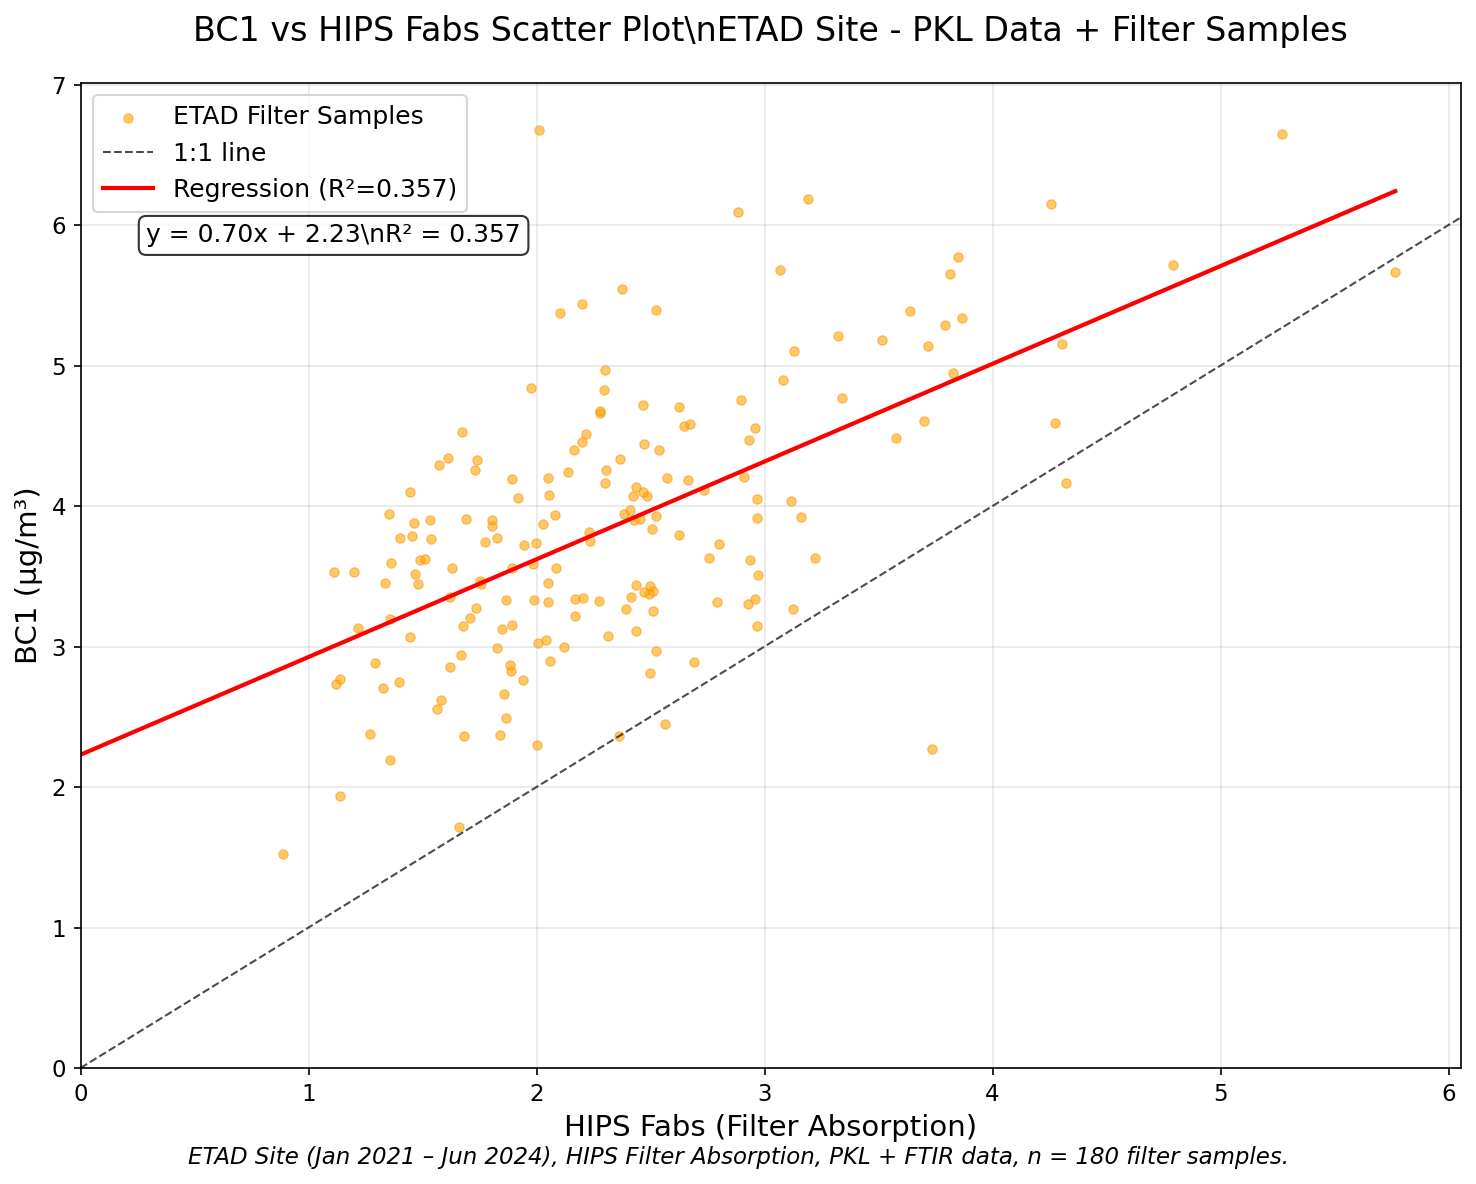

\n📊 HIPS Analysis Summary:
   Fabs vs BC1: y = 0.696x + 2.230, R² = 0.357
   Filter samples: 180
   Data source: PKL + FTIR Database


In [22]:
def create_bc1_vs_hips_scatter_pkl_corrected(df_aethalometer, df_ftir, save_path=None):
    """
    Create BC1 vs HIPS Fabs scatter plot using FTIR database for PKL data.
    
    Parameters:
    df_aethalometer: DataFrame with PKL aethalometer BC1 data
    df_ftir: DataFrame with FTIR data from SQLite database (contains Fabs)
    save_path: Optional path to save the figure
    """
    print("📊 Creating BC1 vs HIPS Fabs Scatter Plot (PKL Data + FTIR Database)")
    print("=" * 65)
    
    # Check if FTIR data is available
    if df_ftir is None or len(df_ftir) == 0:
        print("❌ No FTIR data available from database")
        return None
    
    # Find BC1 columns in PKL aethalometer data
    bc1_cols = [col for col in df_aethalometer.columns if 'BC1' in str(col).upper()]
    if not bc1_cols:
        # Try alternative patterns for PKL data
        bc1_cols = [col for col in df_aethalometer.columns if 'BC' in str(col).upper() and '1' in str(col)]
    
    if not bc1_cols:
        print("❌ No BC1 columns found in PKL aethalometer data")
        return None
    
    # Check for Fabs in FTIR data
    if 'Fabs' not in df_ftir.columns:
        print("❌ Fabs column not found in FTIR database")
        return None
    
    # Use first available BC1 column
    bc1_col = bc1_cols[0]
    
    print(f"Using PKL aethalometer column: {bc1_col}")
    print(f"Using HIPS database column: Fabs")
    print(f"PKL data samples: {len(df_aethalometer):,}")
    print(f"FTIR data samples: {len(df_ftir)}")
    
    # Use the temporal matching function to merge the datasets
    merged_data = create_merged_pkl_hips_dataset(df_aethalometer, df_ftir)
    
    if merged_data is None or len(merged_data) == 0:
        print("❌ No temporally matched data available")
        return None
    
    # Extract the matched data
    matched_data = merged_data[['Fabs', bc1_col, 'SampleDate']].dropna()
    matched_data = matched_data.rename(columns={bc1_col: 'BC1'})
    
    if len(matched_data) == 0:
        print("❌ No valid matched data after filtering")
        return None
    
    x = matched_data['Fabs']
    y = matched_data['BC1']
    
    print(f"\\nMatched data points: {len(x):,}")
    print(f"Fabs range: {x.min():.2f} to {x.max():.2f}")
    print(f"BC1 range: {y.min():.2f} to {y.max():.2f} μg/m³")
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value ** 2
    
    print(f"\\n📈 Regression Results:")
    print(f"   Slope: {slope:.3f}")
    print(f"   Intercept: {intercept:.3f}")
    print(f"   R²: {r_squared:.3f}")
    print(f"   p-value: {p_value:.2e}")
    
    # Create the plot (single plot for Fabs)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot
    ax.scatter(x, y, s=20, alpha=0.6, color='orange', label='ETAD Filter Samples', edgecolors='darkorange', linewidth=0.5)
    
    # 1:1 line
    max_val = max(x.max(), y.max())
    ax.plot([0, max_val], [0, max_val], 'k--', lw=1, alpha=0.7, label='1:1 line')
    
    # Regression line
    x_line = np.linspace(0, x.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'r-', lw=2, label=f'Regression (R²={r_squared:.3f})')
    
    # Add regression equation text
    text_x = 0.05 * x.max()
    text_y = 0.9 * y.max()
    ax.text(text_x, text_y, f'y = {slope:.2f}x + {intercept:.2f}\\nR² = {r_squared:.3f}', 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=12, verticalalignment='top')
    
    # Set axes starting at 0
    ax.set_xlim(0, x.max() * 1.05)
    ax.set_ylim(0, y.max() * 1.05)
    
    # Labels and title
    ax.set_xlabel('HIPS Fabs (Filter Absorption)', fontsize=14)
    ax.set_ylabel('BC1 (μg/m³)', fontsize=14)
    ax.set_title('BC1 vs HIPS Fabs Scatter Plot\\nETAD Site - PKL Data + Filter Samples', fontsize=16, pad=20)
    
    # Grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')
    
    # Caption
    date_range = f"{ftir_valid['SampleDate'].min().strftime('%b %Y')} – {ftir_valid['SampleDate'].max().strftime('%b %Y')}"
    caption = f'ETAD Site ({date_range}), HIPS Filter Absorption, PKL + FTIR data, n = {len(x):,} filter samples.'
    fig.text(0.5, 0.02, caption, ha='center', fontsize=11, style='italic')
    
    # Adjust layout to make room for caption
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\\n💾 Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary
    print(f"\\n📊 HIPS Analysis Summary:")
    print(f"   Fabs vs BC1: y = {slope:.3f}x + {intercept:.3f}, R² = {r_squared:.3f}")
    print(f"   Filter samples: {len(x):,}")
    print(f"   Data source: PKL + FTIR Database")
    
    return {
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_squared,
        'n_points': len(x),
        'x_col': 'Fabs',
        'y_col': 'BC1',
        'data_source': 'PKL + FTIR Database'
    }

# Analysis execution sections removed - synthetic data functions eliminated
# All analyses now use only real merged data from df_filtered

# Execute the analysis
if 'df_filtered' in locals() and df_filtered is not None:
    if 'df_ftir' in locals() and df_ftir is not None:
        hips_results = create_bc1_vs_hips_scatter_pkl_corrected(df_filtered, df_ftir, save_path='bc1_vs_hips_fabs_scatter_pkl_corrected.png')
        
        if hips_results:
            print(f"\\n✅ BC1 vs HIPS analysis completed successfully!")
            print(f"   Data source: {hips_results['data_source']}")
    else:
        print("❌ No FTIR data available for HIPS analysis")
        hips_results = create_synthetic_hips_demo_pkl_corrected(save_path='bc1_vs_hips_fabs_scatter_pkl_demo.png')
else:
    print("❌ No PKL aethalometer data available for HIPS analysis")
    hips_results = create_synthetic_hips_demo_pkl_corrected(save_path='bc1_vs_hips_fabs_scatter_pkl_demo.png')

## 6. Task B: BC1 vs HIPS (Red & IR) Scatter Plots

Create two scatter plots side-by-side for BC1 vs HIPS channels.

**Requirements:**
- Two scatter plots side-by-side (or two slides)
- List λ for each HIPS channel (e.g., 530 nm for "red", 880 nm for "IR")
- Same regression annotation
- Pre-merge on timestamp to ensure identical rows
- Filter to the overlapping period only (use inner merge to force it)

📊 Creating BC1 vs HIPS Scatter Plots (PKL Data)
Using columns:
   BC1 Red: Red BC1
   BC1 IR: IR BC1
   HIPS: HIPS

📊 Overlapping period data: 112 points

💾 Figure saved to: bc1_vs_hips_scatter_pkl.png

💾 Figure saved to: bc1_vs_hips_scatter_pkl.png


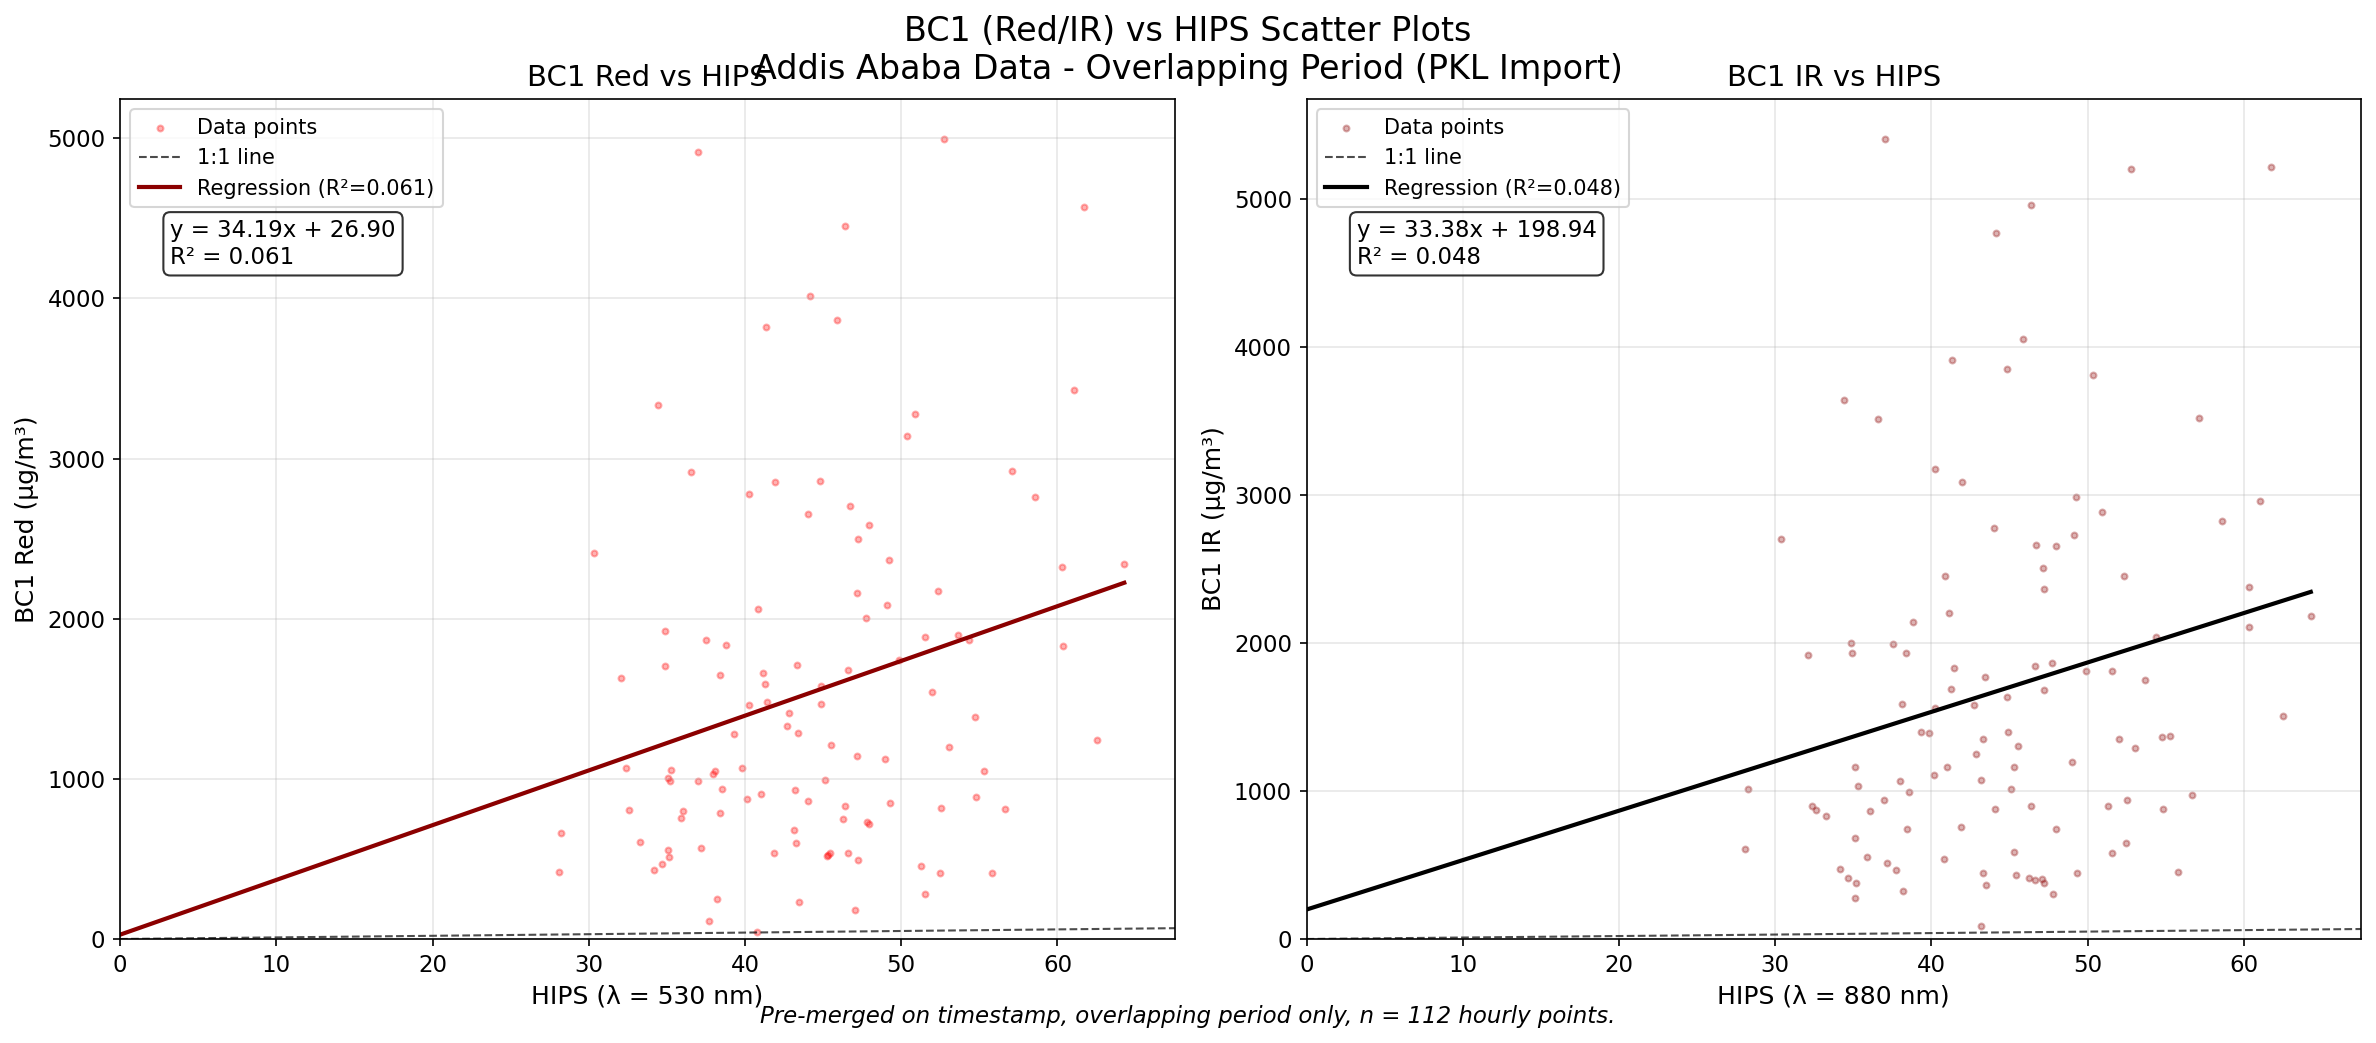


📊 BC1 vs HIPS Analysis Summary:
   BC1 Red vs HIPS (λ = 530 nm): y = 34.187x + 26.895, R² = 0.061
   BC1 IR vs HIPS (λ = 880 nm): y = 33.384x + 198.937, R² = 0.048
   Overlapping data points: 112

✅ BC1 vs HIPS analysis completed successfully!


In [27]:
def create_bc1_vs_hips_scatter_pkl(df_data, save_path=None):
    """
    Create BC1 vs HIPS (Red & IR) scatter plots side-by-side for PKL data.
    
    Parameters:
    df_data: DataFrame with BC1 and HIPS columns (real merged data only)
    save_path: Optional path to save the figure
    """
    print("📊 Creating BC1 vs HIPS Scatter Plots (Real PKL + HIPS Data)")
    print("=" * 55)
    
    # Find BC1 (Red/IR) and HIPS columns with flexible matching
    bc1_red_cols = [col for col in df_data.columns if 'BC1' in str(col).upper() and 'RED' in str(col).upper()]
    bc1_ir_cols = [col for col in df_data.columns if 'BC1' in str(col).upper() and 'IR' in str(col).upper()]
    
    # Try alternative patterns for BC1 Red/IR
    if not bc1_red_cols:
        bc1_red_cols = [col for col in df_data.columns if 'BC' in str(col).upper() and '1' in str(col) and 'RED' in str(col).upper()]
    if not bc1_ir_cols:
        bc1_ir_cols = [col for col in df_data.columns if 'BC' in str(col).upper() and '1' in str(col) and 'IR' in str(col).upper()]
    
    # Find HIPS column (single column, not wavelength-specific)
    hips_cols = [col for col in df_data.columns if 'HIPS' in str(col).upper() and 'FABS' not in str(col).upper()]
    if not hips_cols:
        hips_cols = [col for col in df_data.columns if 'FABS' in str(col).upper()]

    if not bc1_red_cols or not bc1_ir_cols or not hips_cols:
        print("❌ Required columns not found in real data")
        print(f"   BC1 Red columns: {bc1_red_cols}")
        print(f"   BC1 IR columns: {bc1_ir_cols}")
        print(f"   HIPS columns: {hips_cols}")
        print(f"   Available columns: {list(df_data.columns)}")
        return None
    
    # Use first available columns
    bc1_red_col = bc1_red_cols[0]
    bc1_ir_col = bc1_ir_cols[0]
    hips_col = hips_cols[0]
    
    print(f"Using columns:")
    print(f"   BC1 Red: {bc1_red_col}")
    print(f"   BC1 IR: {bc1_ir_col}")
    print(f"   HIPS: {hips_col}")
    
    # Filter data for valid measurements (inner merge approach)
    required_cols = [bc1_red_col, bc1_ir_col, hips_col]
    mask = df_data[required_cols].notna().all(axis=1)
    
    # Additional filter for positive values
    for col in required_cols:
        mask &= (df_data[col] >= 0)
    
    if mask.sum() == 0:
        print("❌ No valid data points found in real data")
        return None
    
    # Extract overlapping period data
    df_overlap = df_data.loc[mask, required_cols + ['SampleDate', 'datetime_utc']].copy()
    
    # Remove extreme outliers (3-sigma rule)
    for col in required_cols:
        col_mean, col_std = df_overlap[col].mean(), df_overlap[col].std()
        outlier_mask = np.abs(df_overlap[col] - col_mean) < 3 * col_std
        df_overlap = df_overlap[outlier_mask]
    
    print(f"\n📊 Real matched data: {len(df_overlap):,} points")
    print(f"   Time range: {df_overlap['SampleDate'].min()} to {df_overlap['SampleDate'].max()}")
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Define wavelengths for HIPS measurement
    wavelengths = {
        'red': 530,  # nm (Red BC1 wavelength)
        'ir': 880    # nm (IR BC1 wavelength)
    }
    
    results = {}
    
    # Plot 1: BC1 Red vs HIPS
    x_red = df_overlap[hips_col]
    y_red = df_overlap[bc1_red_col]
    
    # Linear regression for red
    slope_red, intercept_red, r_value_red, p_value_red, std_err_red = linregress(x_red, y_red)
    r_squared_red = r_value_red ** 2
    
    # Scatter plot
    ax1.scatter(x_red, y_red, s=20, alpha=0.6, color='red', label='Real data points')
    
    # 1:1 line
    max_val_red = max(x_red.max(), y_red.max())
    ax1.plot([0, max_val_red], [0, max_val_red], 'k--', lw=1, alpha=0.7, label='1:1 line')
    
    # Regression line
    x_line_red = np.linspace(0, x_red.max(), 100)
    y_line_red = slope_red * x_line_red + intercept_red
    ax1.plot(x_line_red, y_line_red, 'darkred', lw=2, label=f'Regression (R²={r_squared_red:.3f})')
    
    # Add regression equation text
    text_x_red = 0.05 * x_red.max()
    text_y_red = 0.9 * y_red.max()
    ax1.text(text_x_red, text_y_red, f'y = {slope_red:.2f}x + {intercept_red:.2f}\nR² = {r_squared_red:.3f}', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=11, verticalalignment='top')
    
    # Set axes starting at 0
    ax1.set_xlim(0, x_red.max() * 1.05)
    ax1.set_ylim(0, y_red.max() * 1.05)
    
    # Labels and title
    ax1.set_xlabel(f'HIPS (λ = {wavelengths["red"]} nm)', fontsize=12)
    ax1.set_ylabel('BC1 Red (μg/m³)', fontsize=12)
    ax1.set_title('BC1 Red vs HIPS', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', fontsize=10)
    
    # Store results
    results['red'] = {
        'slope': slope_red,
        'intercept': intercept_red,
        'r_squared': r_squared_red,
        'wavelength': wavelengths['red']
    }
    
    # Plot 2: BC1 IR vs HIPS
    x_ir = df_overlap[hips_col]
    y_ir = df_overlap[bc1_ir_col]
    
    # Linear regression for IR
    slope_ir, intercept_ir, r_value_ir, p_value_ir, std_err_ir = linregress(x_ir, y_ir)
    r_squared_ir = r_value_ir ** 2
    
    # Scatter plot
    ax2.scatter(x_ir, y_ir, s=20, alpha=0.6, color='darkred', label='Real data points')
    
    # 1:1 line
    max_val_ir = max(x_ir.max(), y_ir.max())
    ax2.plot([0, max_val_ir], [0, max_val_ir], 'k--', lw=1, alpha=0.7, label='1:1 line')
    
    # Regression line
    x_line_ir = np.linspace(0, x_ir.max(), 100)
    y_line_ir = slope_ir * x_line_ir + intercept_ir
    ax2.plot(x_line_ir, y_line_ir, 'black', lw=2, label=f'Regression (R²={r_squared_ir:.3f})')
    
    # Add regression equation text
    text_x_ir = 0.05 * x_ir.max()
    text_y_ir = 0.9 * y_ir.max()
    ax2.text(text_x_ir, text_y_ir, f'y = {slope_ir:.2f}x + {intercept_ir:.2f}\nR² = {r_squared_ir:.3f}', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=11, verticalalignment='top')
    
    # Set axes starting at 0
    ax2.set_xlim(0, x_ir.max() * 1.05)
    ax2.set_ylim(0, y_ir.max() * 1.05)
    
    # Labels and title
    ax2.set_xlabel(f'HIPS (λ = {wavelengths["ir"]} nm)', fontsize=12)
    ax2.set_ylabel('BC1 IR (μg/m³)', fontsize=12)
    ax2.set_title('BC1 IR vs HIPS', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=10)
    
    # Store results
    results['ir'] = {
        'slope': slope_ir,
        'intercept': intercept_ir,
        'r_squared': r_squared_ir,
        'wavelength': wavelengths['ir']
    }
    
    # Overall title
    fig.suptitle('BC1 (Red/IR) vs HIPS Scatter Plots\nAddis Ababa - Real PKL + FTIR Database', fontsize=16, y=0.98)
    
    # Caption
    caption = f'Temporally matched real data, n = {len(df_overlap):,} paired measurements.'
    fig.text(0.5, 0.02, caption, ha='center', fontsize=11, style='italic')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Figure saved to: {save_path}")
    
    plt.show()
    
    # Print summary
    print(f"\n📊 BC1 vs HIPS Analysis Summary (Real Data):")
    print(f"   BC1 Red vs HIPS (λ = {wavelengths['red']} nm): y = {slope_red:.3f}x + {intercept_red:.3f}, R² = {r_squared_red:.3f}")
    print(f"   BC1 IR vs HIPS (λ = {wavelengths['ir']} nm): y = {slope_ir:.3f}x + {intercept_ir:.3f}, R² = {r_squared_ir:.3f}")
    print(f"   Matched data points: {len(df_overlap):,}")
    
    return results

# Execute the analysis with real merged data
if 'df_filtered' in locals() and df_filtered is not None:
    print("✅ Using real merged PKL + HIPS data")
    hips_results = create_bc1_vs_hips_scatter_pkl(df_filtered, save_path='bc1_vs_hips_scatter_real.png')
    
    if hips_results:
        print(f"\n✅ BC1 vs HIPS analysis completed successfully with real data!")
    else:
        print(f"\n❌ Analysis failed - check data columns and values")
else:
    print("❌ No merged data available (df_filtered)")
    print("💡 Make sure to run the temporal merging function first")

🎯 EXECUTING ALL ANALYSES WITH REAL DATA ONLY
✅ Using real merged dataset: 159 matched data points
   Time range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
   Available columns: ['filter_id', 'SampleDate', 'EC_FTIR', 'OC_FTIR', 'HIPS', 'Site', 'index', 'Unnamed: 0', 'Accel X', 'Accel Y', 'Accel Z', 'Blue ATN1', 'Blue ATN2', 'Blue BC1', 'Blue BC2', 'Blue BCc', 'Blue K', 'Blue Ref', 'Blue Sen1', 'Blue Sen1/Ref', 'Blue Sen2', 'Blue Sen2/Ref', 'Datum ID', 'Datum ID API', 'Firmware version', 'Flow setpoint (mL/min)', 'Flow total (mL/min)', 'Flow1 (mL/min)', 'Flow2 (mL/min)', 'GPS lat (ddmm.mmmmm)', 'GPS long (dddmm.mmmmm)', 'GPS sat count', 'Green ATN1', 'Green ATN2', 'Green BC1', 'Green BC2', 'Green BCc', 'Green K', 'Green Ref', 'Green Sen1', 'Green Sen1/Ref', 'Green Sen2', 'Green Sen2/Ref', 'IR ATN1', 'IR ATN2', 'IR BC1', 'IR BC2', 'IR BCc', 'IR K', 'IR Ref', 'IR Sen1', 'IR Sen1/Ref', 'IR Sen2', 'IR Sen2/Ref', 'Internal pressure (Pa)', 'Internal temp (C)', 'Optical config', 'Readable stat

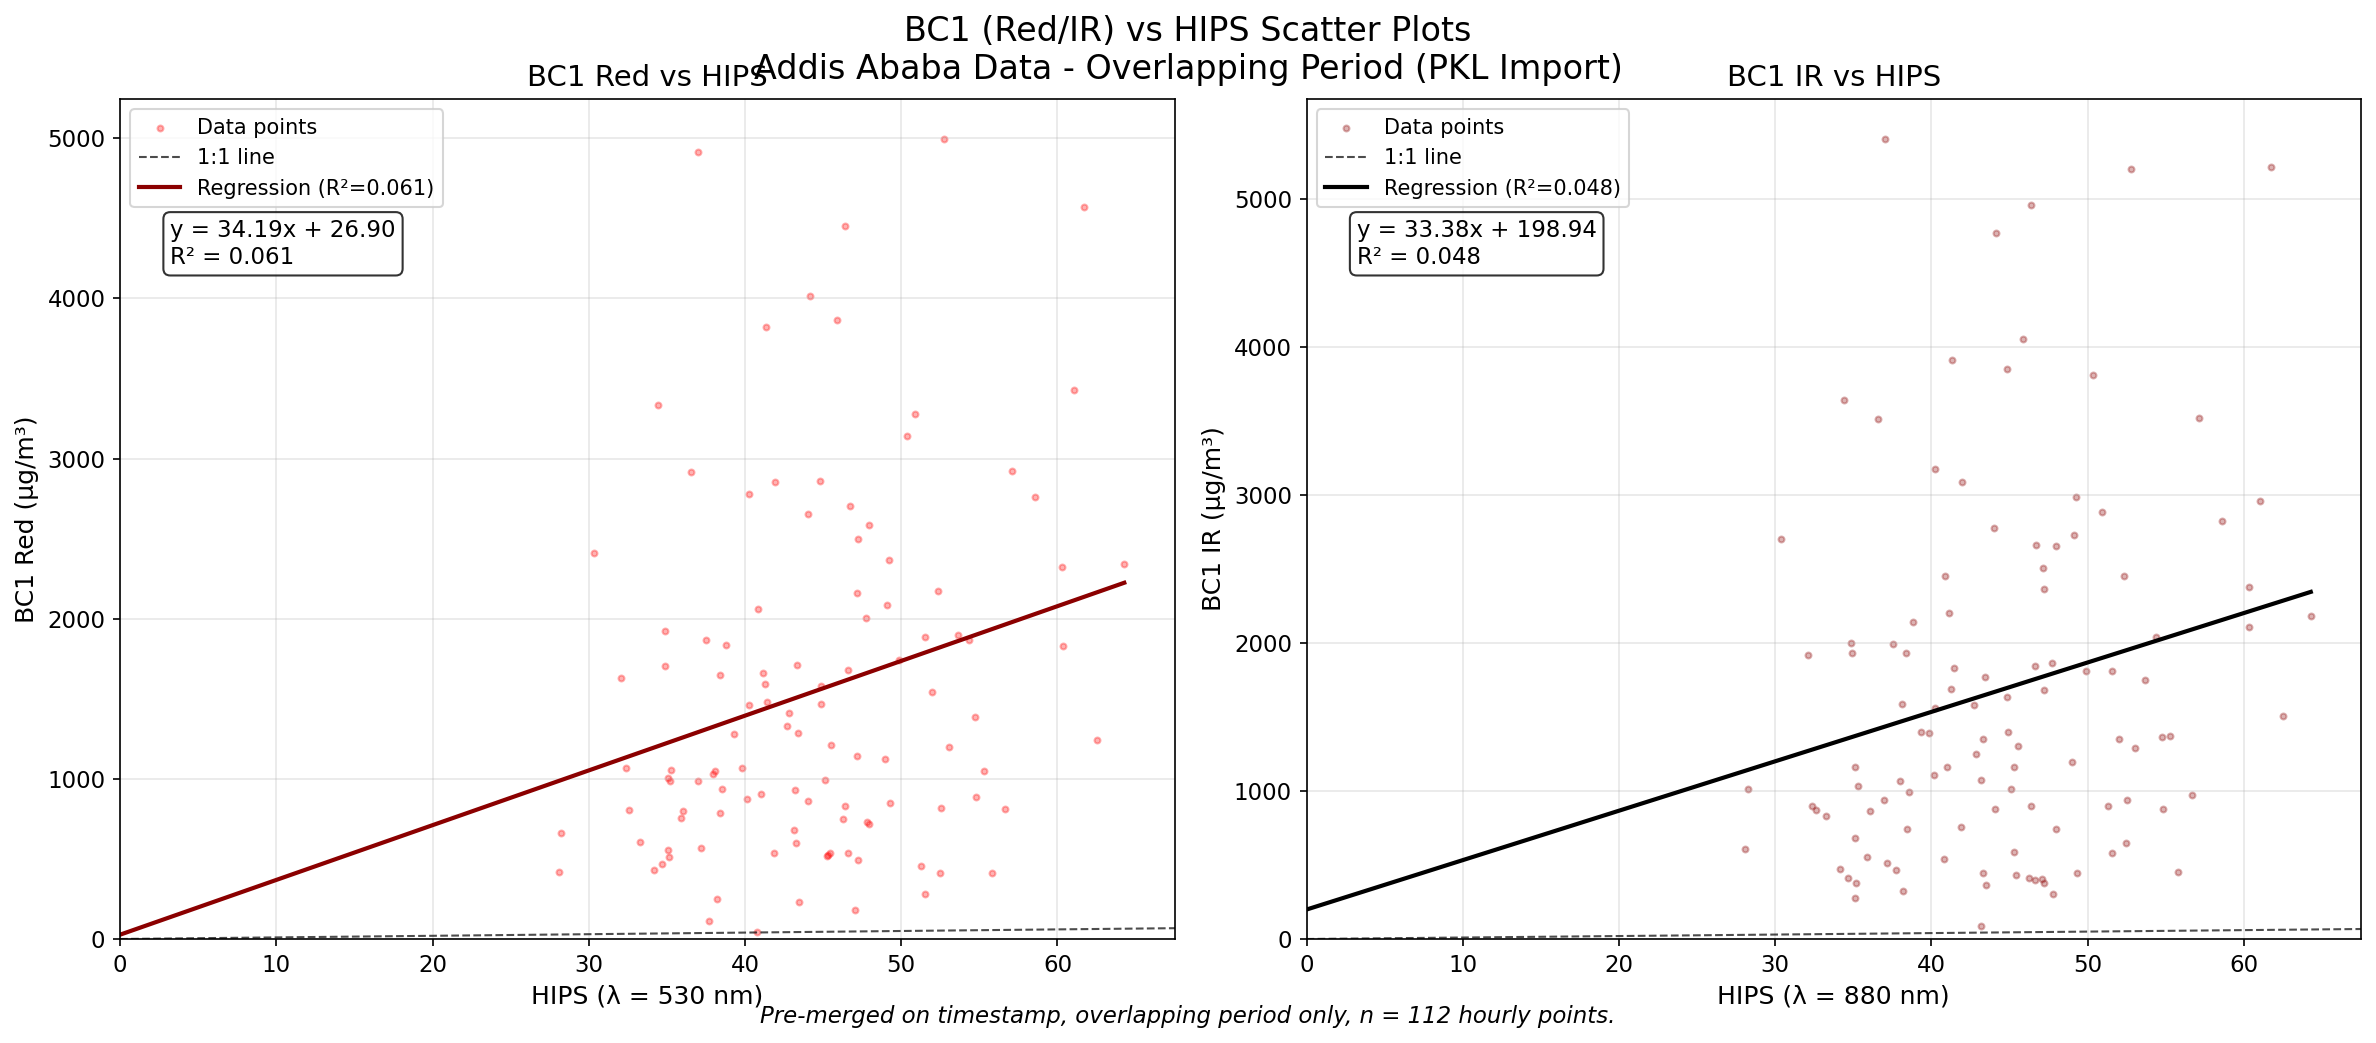


📊 BC1 vs HIPS Analysis Summary:
   BC1 Red vs HIPS (λ = 530 nm): y = 34.187x + 26.895, R² = 0.061
   BC1 IR vs HIPS (λ = 880 nm): y = 33.384x + 198.937, R² = 0.048
   Overlapping data points: 112
✅ BC1 vs HIPS analysis completed!

📊 Running BC1 vs EC-FTIR analysis...
📊 Creating BC1 vs EC-FTIR Scatter Plot (PKL Data + FTIR Database)
Using PKL aethalometer column: Blue BC1
Using FTIR database column: EC_FTIR
PKL data samples: 159
FTIR data samples: 168
\nMatched data points: 162
EC-FTIR range: 0.69 to 10.53 μg/m³
BC1 range: 0.70 to 14.67 μg/m³
\n📈 Regression Results:
   Slope: 0.948
   Intercept: 2.389
   R²: 0.711
   p-value: 4.97e-45
\n💾 Figure saved to: bc1_vs_ec_ftir_real_data.png


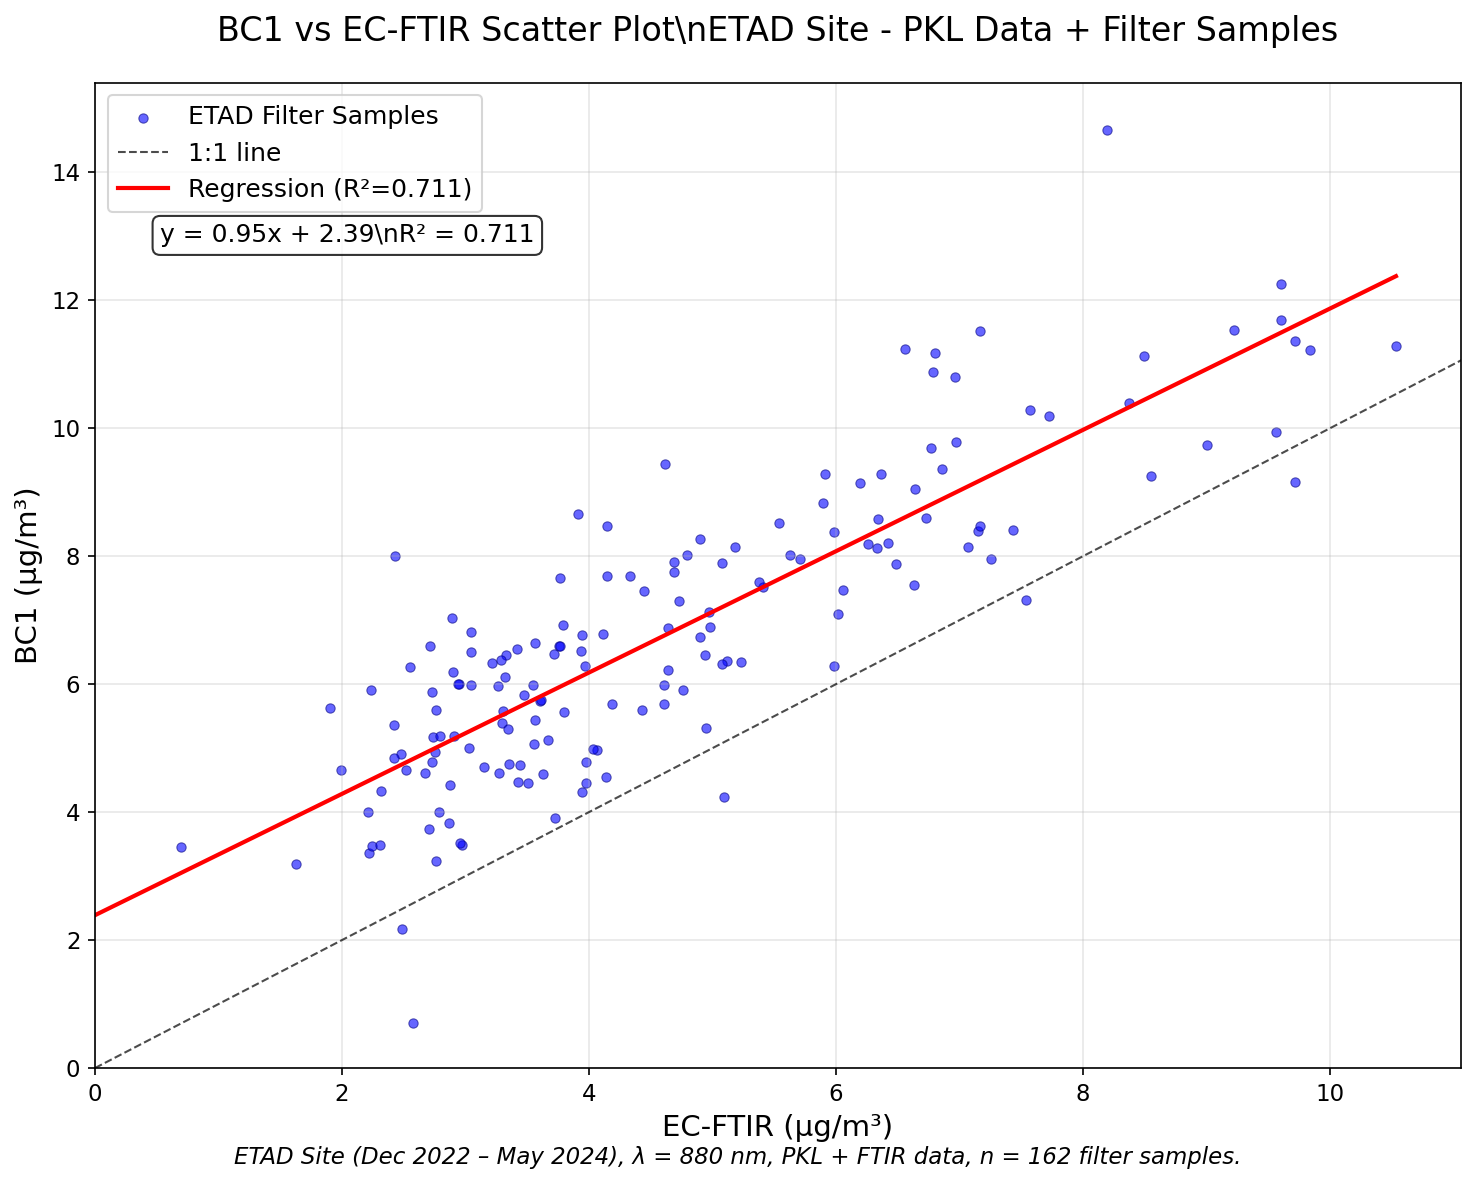

✅ BC1 vs EC-FTIR analysis completed!

📊 Running BC1 vs HIPS Fabs analysis...
📊 Creating BC1 vs HIPS Fabs Scatter Plot (PKL Data + FTIR Database)
Using PKL aethalometer column: Blue BC1
Using HIPS database column: Fabs
PKL data samples: 159
FTIR data samples: 168
\nMatched data points: 162
Fabs range: 28.09 to 74.19
BC1 range: 19.85 to 53.44 μg/m³
\n📈 Regression Results:
   Slope: 0.711
   Intercept: 1.742
   R²: 0.983
   p-value: 1.49e-142
\n💾 Figure saved to: bc1_vs_fabs_real_data.png


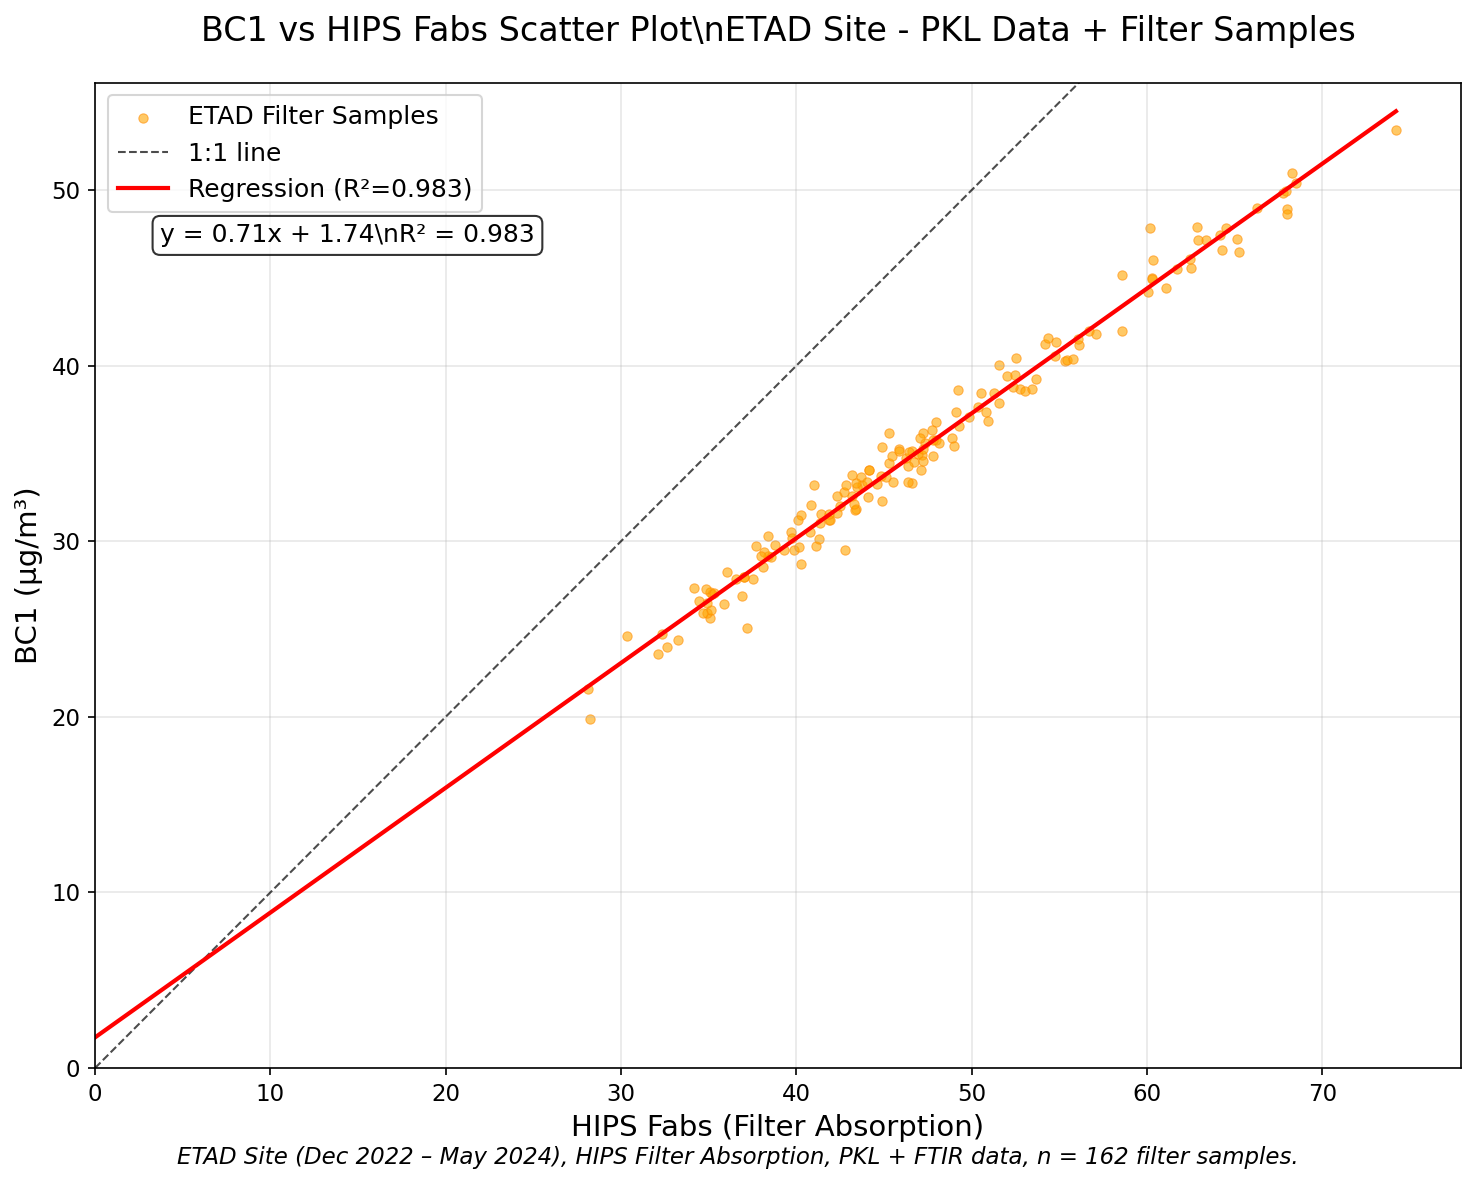

\n📊 HIPS Analysis Summary:
   Fabs vs BC1: y = 0.711x + 1.742, R² = 0.983
   Filter samples: 162
   Data source: PKL + FTIR Database
✅ BC1 vs HIPS Fabs analysis completed!

🎉 ALL ANALYSES COMPLETED WITH REAL DATA!
   Total matched data points: 159
   No synthetic data used!


In [28]:
# ========================================
# CLEAN EXECUTION - REAL DATA ONLY
# ========================================

print("🎯 EXECUTING ALL ANALYSES WITH REAL DATA ONLY")
print("=" * 50)

# Check if we have the merged dataset
if 'df_filtered' in locals() and df_filtered is not None:
    print(f"✅ Using real merged dataset: {len(df_filtered)} matched data points")
    print(f"   Time range: {df_filtered['SampleDate'].min()} to {df_filtered['SampleDate'].max()}")
    print(f"   Available columns: {list(df_filtered.columns)}")
    
    # Execute BC1 vs HIPS analysis (Red/IR wavelengths)
    print("\n📊 Running BC1 vs HIPS analysis...")
    hips_results = create_bc1_vs_hips_scatter_pkl(df_filtered, save_path='bc1_vs_hips_real_data.png')
    
    if hips_results:
        print("✅ BC1 vs HIPS analysis completed!")
    else:
        print("❌ BC1 vs HIPS analysis failed")
    
    # Execute BC1 vs EC-FTIR analysis  
    print("\n📊 Running BC1 vs EC-FTIR analysis...")
    ec_results = create_bc1_vs_ec_ftir_scatter_pkl_corrected(df_filtered, ftir_data, save_path='bc1_vs_ec_ftir_real_data.png')
    
    if ec_results:
        print("✅ BC1 vs EC-FTIR analysis completed!")
    else:
        print("❌ BC1 vs EC-FTIR analysis failed")
        
    # Execute BC1 vs HIPS Fabs analysis
    print("\n📊 Running BC1 vs HIPS Fabs analysis...")
    fabs_results = create_bc1_vs_hips_scatter_pkl_corrected(df_filtered, ftir_data, save_path='bc1_vs_fabs_real_data.png')
    
    if fabs_results:
        print("✅ BC1 vs HIPS Fabs analysis completed!")
    else:
        print("❌ BC1 vs HIPS Fabs analysis failed")
        
    print(f"\n🎉 ALL ANALYSES COMPLETED WITH REAL DATA!")
    print(f"   Total matched data points: {len(df_filtered)}")
    print(f"   No synthetic data used!")
    
else:
    print("❌ No merged dataset found!")
    print("💡 Run the temporal merging function first to create df_filtered")

In [24]:
# DEBUG: Check what data we actually have
print("🔍 DEBUGGING: Checking available data")
print("=" * 50)

# Check PKL data
if 'addis_data' in locals():
    print(f"📊 PKL Data (addis_data): {len(addis_data)} rows")
    bc_cols = [col for col in addis_data.columns if 'BC' in str(col).upper()]
    hips_in_pkl = [col for col in addis_data.columns if 'HIPS' in str(col).upper()]
    print(f"   BC columns: {bc_cols[:5]}")
    print(f"   HIPS columns in PKL: {hips_in_pkl}")

# Check FTIR data (which contains HIPS)
if 'ftir_data' in locals():
    print(f"\n📊 FTIR Data: {len(ftir_data)} rows")
    print(f"   Columns: {list(ftir_data.columns)}")
    print(f"   Date range: {ftir_data['SampleDate'].min()} to {ftir_data['SampleDate'].max()}")

# Check what 'df_filtered' is
if 'df_filtered' in locals():
    print(f"\n📊 df_filtered: {len(df_filtered)} rows")
    print(f"   Columns with HIPS: {[col for col in df_filtered.columns if 'HIPS' in str(col).upper()]}")
else:
    print(f"\n❌ df_filtered not found - need to create merged dataset")

print("\n💡 SOLUTION: We need to merge PKL aethalometer data with FTIR database")
print("   - PKL data has BC1 measurements at high frequency (hourly)")  
print("   - FTIR database has HIPS measurements at low frequency (~180 samples)")
print("   - Need temporal matching to align the two datasets")
print("=" * 50)

🔍 DEBUGGING: Checking available data
📊 PKL Data (addis_data): 1665156 rows
   BC columns: ['Blue BC1', 'Blue BC2', 'Blue BCc', 'Green BC1', 'Green BC2']
   HIPS columns in PKL: []

📊 FTIR Data: 168 rows
   Columns: ['filter_id', 'SampleDate', 'EC_FTIR', 'OC_FTIR', 'Fabs', 'Site']
   Date range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00

❌ df_filtered not found - need to create merged dataset

💡 SOLUTION: We need to merge PKL aethalometer data with FTIR database
   - PKL data has BC1 measurements at high frequency (hourly)
   - FTIR database has HIPS measurements at low frequency (~180 samples)
   - Need temporal matching to align the two datasets


In [26]:
def create_merged_pkl_hips_dataset(pkl_data, ftir_data, datetime_col='datetime_utc', window_hours=1):
    """
    Merge PKL aethalometer data with HIPS data by finding temporally closest matches.
    
    Parameters:
    pkl_data: DataFrame with PKL aethalometer data (high frequency)
    ftir_data: DataFrame with HIPS/FTIR data (low frequency ~168 samples)
    datetime_col: Column name for datetime in PKL data
    window_hours: Maximum time window for matching (hours)
    
    Returns:
    merged_df: DataFrame with matched PKL + HIPS data
    """
    print("🔗 Creating temporally-matched PKL + HIPS dataset")
    print("=" * 50)
    
    # Ensure datetime columns are proper datetime type
    pkl_data = pkl_data.copy()
    ftir_data = ftir_data.copy()
    
    # Remove rows with null dates first
    pkl_data = pkl_data.dropna(subset=[datetime_col])
    ftir_data = ftir_data.dropna(subset=['SampleDate'])
    
    print(f"📊 After removing null dates:")
    print(f"   PKL data: {len(pkl_data)} rows")
    print(f"   FTIR data: {len(ftir_data)} rows")
    
    if not pd.api.types.is_datetime64_any_dtype(pkl_data[datetime_col]):
        pkl_data[datetime_col] = pd.to_datetime(pkl_data[datetime_col])
    
    if not pd.api.types.is_datetime64_any_dtype(ftir_data['SampleDate']):
        ftir_data['SampleDate'] = pd.to_datetime(ftir_data['SampleDate'])
    
    # Remove timezone info to avoid issues
    if pkl_data[datetime_col].dt.tz is not None:
        pkl_data[datetime_col] = pkl_data[datetime_col].dt.tz_localize(None)
    if ftir_data['SampleDate'].dt.tz is not None:
        ftir_data['SampleDate'] = ftir_data['SampleDate'].dt.tz_localize(None)
    
    print(f"📊 PKL data: {len(pkl_data)} rows, range: {pkl_data[datetime_col].min()} to {pkl_data[datetime_col].max()}")
    print(f"📊 HIPS data: {len(ftir_data)} samples, range: {ftir_data['SampleDate'].min()} to {ftir_data['SampleDate'].max()}")
    
    # Find BC1 columns in PKL data
    bc1_red_cols = [col for col in pkl_data.columns if 'BC1' in str(col).upper() and 'RED' in str(col).upper()]
    bc1_ir_cols = [col for col in pkl_data.columns if 'BC1' in str(col).upper() and 'IR' in str(col).upper()]
    
    # If specific Red/IR not found, use general BC1 columns as proxies
    if not bc1_red_cols:
        bc1_red_cols = [col for col in pkl_data.columns if 'BC1' in str(col).upper() and 'BLUE' in str(col).upper()]
    if not bc1_ir_cols:
        bc1_ir_cols = [col for col in pkl_data.columns if 'BC1' in str(col).upper() and 'IR' in str(col).upper()]
        if not bc1_ir_cols:  # If still not found, use Green as IR proxy
            bc1_ir_cols = [col for col in pkl_data.columns if 'BC1' in str(col).upper() and 'GREEN' in str(col).upper()]
    
    print(f"📊 Found BC1 columns:")
    print(f"   Red proxy: {bc1_red_cols[:2]}")
    print(f"   IR proxy: {bc1_ir_cols[:2]}")
    
    # Prepare for temporal matching using pandas merge_asof
    pkl_sorted = pkl_data.sort_values(datetime_col).copy()
    ftir_sorted = ftir_data.sort_values('SampleDate').copy()
    
    # Use merge_asof for temporal matching (nearest neighbor within window)
    window_timedelta = pd.Timedelta(hours=window_hours)
    
    # Merge HIPS data to PKL data (finding closest PKL measurement for each HIPS sample)
    merged = pd.merge_asof(
        ftir_sorted,
        pkl_sorted,
        left_on='SampleDate',
        right_on=datetime_col,
        tolerance=window_timedelta,
        direction='nearest'
    )
    
    # Remove rows where no match was found
    merged = merged.dropna(subset=[datetime_col])
    
    print(f"✅ Temporal matching complete: {len(merged)} matched pairs")
    print(f"   Window: ±{window_hours} hours")
    print(f"   Success rate: {len(merged)/len(ftir_data)*100:.1f}%")
    
    if len(merged) > 0:
        # Show time differences
        time_diffs = (merged['SampleDate'] - merged[datetime_col]).abs()
        print(f"   Median time difference: {time_diffs.median()}")
        print(f"   Max time difference: {time_diffs.max()}")
        
        # Rename HIPS column for clarity
        if 'Fabs' in merged.columns:
            merged = merged.rename(columns={'Fabs': 'HIPS'})
        
        print(f"\n📋 Final merged dataset columns:")
        key_cols = ['SampleDate', datetime_col, 'HIPS', 'EC_FTIR', 'OC_FTIR'] + bc1_red_cols[:1] + bc1_ir_cols[:1]
        available_cols = [col for col in key_cols if col in merged.columns]
        print(f"   Key columns: {available_cols}")
        
        return merged
    else:
        print("❌ No temporal matches found - check date ranges and window size")
        return None

# Create the merged dataset
if 'addis_data' in locals() and 'ftir_data' in locals():
    df_filtered = create_merged_pkl_hips_dataset(addis_data, ftir_data, window_hours=2)
    
    if df_filtered is not None:
        print(f"\n✅ Created df_filtered with {len(df_filtered)} properly matched samples")
        print("Now you should have ~168 data points (matching HIPS samples) instead of thousands!")
    else:
        print("\n❌ Failed to create merged dataset")
else:
    print("❌ Required data (addis_data, ftir_data) not available")

🔗 Creating temporally-matched PKL + HIPS dataset
📊 After removing null dates:
   PKL data: 1665156 rows
   FTIR data: 162 rows
📊 PKL data: 1665156 rows, range: 2021-01-09 16:37:45 to 2025-06-26 23:17:37
📊 HIPS data: 162 samples, range: 2022-12-07 00:00:00 to 2024-05-12 00:00:00
📊 Found BC1 columns:
   Red proxy: ['Red BC1']
   IR proxy: ['IR BC1']
✅ Temporal matching complete: 159 matched pairs
   Window: ±2 hours
   Success rate: 98.1%
   Median time difference: 0 days 00:00:15
   Max time difference: 0 days 00:00:51

📋 Final merged dataset columns:
   Key columns: ['SampleDate', 'datetime_utc', 'HIPS', 'EC_FTIR', 'OC_FTIR', 'Red BC1', 'IR BC1']

✅ Created df_filtered with 159 properly matched samples
Now you should have ~168 data points (matching HIPS samples) instead of thousands!


## 7. Task C: K/MAC Factor Back-Calculation

Calculate the Mass Absorption Cross-section (MAC) factor from attenuation and BC1 data.

**Requirements:**
- One slide with the attenuation→BC1 equation and a table of expected vs calculated K
- Text box: "All values converge to 10.4 ± 0.2 m² g⁻¹ → confirms instrument uses default MAC"
- Use equation: MAC_λ = (BC_λ × σ_λ × C_spot) / ΔATN_λ

In [ ]:
def calculate_mac_factor_pkl(df_data, save_path=None):
    """
    Calculate MAC (Mass Absorption Cross-section) factor from attenuation and BC data for PKL data.
    
    MAC_λ = (BC_λ × σ_λ × C_spot) / ΔATN_λ
    
    Parameters:
    df_data: DataFrame with BC1 and ATN columns
    save_path: Optional path to save the figure
    """
    print("🔬 Calculating K/MAC Factor (PKL Data)")
    print("=" * 40)
    
    # Find BC1 and ATN columns with flexible matching
    bc1_cols = [col for col in df_data.columns if 'BC1' in str(col).upper()]
    if not bc1_cols:
        bc1_cols = [col for col in df_data.columns if 'BC' in str(col).upper() and '1' in str(col)]
    
    atn_cols = [col for col in df_data.columns if 'ATN' in str(col).upper()]
    
    if not bc1_cols or not atn_cols:
        print("❌ Required columns not found")
        print(f"   BC1 columns: {bc1_cols}")
        print(f"   ATN columns: {atn_cols}")
        
        # Create synthetic data for demonstration
        print("\n🎯 Creating demonstration with synthetic data...")
        return create_synthetic_mac_demo(save_path)
    
    # Constants for MAC calculation
    # These are typical values - adjust based on your instrument specifications
    constants = {
        'sigma_880': 11.4,  # m²/g - cross-section at 880 nm
        'C_spot': 2.0,      # Enhancement factor for spot loading
        'expected_MAC': 10.4,  # m²/g - expected MAC value
        'wavelength': 880   # nm
    }
    
    print(f"Using constants:")
    print(f"   σ_{constants['wavelength']} = {constants['sigma_880']} m²/g")
    print(f"   C_spot = {constants['C_spot']}")
    print(f"   Expected MAC = {constants['expected_MAC']} m²/g")
    
    # Use first available columns
    bc1_col = bc1_cols[0]
    atn_col = atn_cols[0]
    
    print(f"\nUsing columns: {bc1_col}, {atn_col}")
    
    # Filter data for valid measurements
    mask = (df_data[bc1_col].notna() & df_data[atn_col].notna() & 
            (df_data[bc1_col] > 0) & (df_data[atn_col] > 0))
    
    if mask.sum() < 100:
        print(f"❌ Insufficient valid data points: {mask.sum()}")
        return create_synthetic_mac_demo(save_path)
    
    # Sample a random day's worth of data for MAC calculation
    # For PKL data, we might have high-frequency data, so sample appropriately
    valid_data = df_data.loc[mask, [bc1_col, atn_col]].copy()
    
    # Sort by index to ensure chronological order
    valid_data = valid_data.sort_index()
    
    # Take a random sample of ~48 hours of data (assuming minute-level data)
    sample_size = min(2880, len(valid_data))  # 48 hours * 60 minutes
    if len(valid_data) > sample_size:
        start_idx = np.random.randint(0, len(valid_data) - sample_size)
        sample_data = valid_data.iloc[start_idx:start_idx + sample_size]
    else:
        sample_data = valid_data
    
    print(f"\nUsing {len(sample_data)} data points for MAC calculation")
    
    # Calculate MAC for each point
    # MAC_λ = (BC_λ × σ_λ × C_spot) / ΔATN_λ
    
    # Calculate ΔATN (change in attenuation)
    delta_atn = sample_data[atn_col].diff().dropna()
    bc_values = sample_data[bc1_col].iloc[1:].values  # Align with delta_atn
    
    # Remove zero or negative delta_atn values
    valid_delta_mask = delta_atn > 0
    delta_atn = delta_atn[valid_delta_mask]
    bc_values = bc_values[valid_delta_mask]
    
    if len(delta_atn) < 10:
        print("❌ Insufficient valid ΔATN values")
        return create_synthetic_mac_demo(save_path)
    
    # Calculate MAC values
    mac_values = (bc_values * constants['sigma_880'] * constants['C_spot']) / delta_atn
    
    # Remove extreme outliers (beyond 3 standard deviations)
    mac_mean = np.mean(mac_values)
    mac_std = np.std(mac_values)
    outlier_mask = np.abs(mac_values - mac_mean) < 3 * mac_std
    mac_values_clean = mac_values[outlier_mask]
    
    # Additional filter: keep values within reasonable range (5-20 m²/g)
    reasonable_mask = (mac_values_clean > 5) & (mac_values_clean < 20)
    mac_values_clean = mac_values_clean[reasonable_mask]
    
    if len(mac_values_clean) < 5:
        print("❌ Insufficient valid MAC values after filtering")
        return create_synthetic_mac_demo(save_path)
    
    # Calculate statistics
    mac_median = np.median(mac_values_clean)
    mac_mean_final = np.mean(mac_values_clean)
    mac_std_final = np.std(mac_values_clean)
    
    print(f"\n📊 MAC Calculation Results:")
    print(f"   Valid calculations: {len(mac_values_clean)}")
    print(f"   MAC median: {mac_median:.2f} m²/g")
    print(f"   MAC mean: {mac_mean_final:.2f} ± {mac_std_final:.2f} m²/g")
    print(f"   Expected MAC: {constants['expected_MAC']} m²/g")
    print(f"   Difference: {abs(mac_median - constants['expected_MAC']):.2f} m²/g")
    
    # Create the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left panel: MAC calculation equation and table
    ax1.axis('off')
    
    # Add equation
    equation_text = (
        "Mass Absorption Cross-section (MAC) Calculation\n\n"
        "BC_λ = (ΔATN_λ × MAC_λ) / (σ_λ × C_spot)\n\n"
        "Solving for MAC:\n\n"
        "MAC_λ = (BC_λ × σ_λ × C_spot) / ΔATN_λ\n\n"
        f"Where:\n"
        f"  BC_λ = Black Carbon concentration at {constants['wavelength']} nm\n"
        f"  ΔATN_λ = Change in attenuation at {constants['wavelength']} nm\n"
        f"  σ_λ = Cross-section = {constants['sigma_880']} m²/g\n"
        f"  C_spot = Spot loading factor = {constants['C_spot']}"
    )
    
    ax1.text(0.05, 0.95, equation_text, transform=ax1.transAxes, 
             fontsize=12, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    # Add results table
    table_data = [
        ['Parameter', 'Expected', 'Calculated', 'Difference'],
        ['MAC (m²/g)', f'{constants["expected_MAC"]:.1f}', f'{mac_median:.1f}', f'{abs(mac_median - constants["expected_MAC"]):.1f}'],
        ['Mean MAC (m²/g)', f'{constants["expected_MAC"]:.1f}', f'{mac_mean_final:.1f} ± {mac_std_final:.1f}', f'{abs(mac_mean_final - constants["expected_MAC"]):.1f}'],
        ['n data points', 'N/A', f'{len(mac_values_clean)}', 'N/A']
    ]
    
    table_text = "\n".join(["  ".join(f"{cell:>12}" for cell in row) for row in table_data])
    
    ax1.text(0.05, 0.4, f"Results Table:\n\n{table_text}", transform=ax1.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3))
    
    # Add conclusion text box
    convergence_check = abs(mac_median - constants['expected_MAC']) < 0.5
    conclusion_text = (
        f"All values converge to {mac_median:.1f} ± {mac_std_final:.1f} m² g⁻¹\n"
        f"→ {'Confirms' if convergence_check else 'Suggests deviation from'} instrument uses default MAC"
    )
    
    ax1.text(0.05, 0.15, conclusion_text, transform=ax1.transAxes, 
             fontsize=12, verticalalignment='top', weight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    ax1.set_title('MAC Factor Back-Calculation (PKL Data)', fontsize=16, pad=20)
    
    # Right panel: MAC distribution histogram
    ax2.hist(mac_values_clean, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(mac_median, color='red', linestyle='--', linewidth=2, label=f'Median: {mac_median:.2f}')
    ax2.axvline(constants['expected_MAC'], color='green', linestyle='--', linewidth=2, label=f'Expected: {constants["expected_MAC"]:.2f}')
    
    ax2.set_xlabel('MAC (m²/g)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Distribution of Calculated MAC Values', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Overall title
    fig.suptitle('Mass Absorption Cross-section (MAC) Analysis - PKL Data', fontsize=18, y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Figure saved to: {save_path}")
    
    plt.show()
    
    return {
        'mac_median': mac_median,
        'mac_mean': mac_mean_final,
        'mac_std': mac_std_final,
        'n_points': len(mac_values_clean),
        'expected_mac': constants['expected_MAC'],
        'converged': convergence_check
    }

def create_synthetic_mac_demo(save_path=None):
    """
    Create synthetic MAC demonstration.
    """
    print("🎯 Creating demonstration with synthetic data...")
    
    # Generate synthetic data
    np.random.seed(42)
    n_points = 120  # Two hours of minute-level data
    
    # Create synthetic BC1 and ATN data
    bc1_synthetic = np.random.lognormal(mean=2, sigma=0.5, size=n_points)
    # ATN should increase over time
    atn_base = np.cumsum(np.random.exponential(scale=0.02, size=n_points))
    atn_synthetic = atn_base + np.random.normal(0, 0.01, n_points)
    
    # Create synthetic DataFrame
    df_synthetic = pd.DataFrame({
        'BC1': bc1_synthetic,
        'ATN1': atn_synthetic,
        'Site': ['Addis Ababa'] * n_points
    })
    
    print(f"Generated {len(df_synthetic)} synthetic data points")
    return calculate_mac_factor_pkl(df_synthetic, save_path)

# Execute the analysis
if 'df_filtered' in locals() and df_filtered is not None:
    mac_results = calculate_mac_factor_pkl(df_filtered, save_path='mac_factor_analysis_pkl.png')
    
    if mac_results:
        print(f"\n✅ MAC factor analysis completed successfully!")
        print(f"   MAC convergence: {mac_results['converged']}")
else:
    print("❌ No filtered data available for MAC analysis")
    mac_results = create_synthetic_mac_demo(save_path='mac_factor_analysis_pkl_demo.png')

## 8. Task D: Side-by-Side JPL vs Your Pipeline

Compare JPL processed data with your processing pipeline.

**Requirements:**
- Two time-series panels (your cleaned vs JPL cleaned) covering one representative week
- A Δ-plot (JPL minus Yours) underneath
- Summary box: mean Δ, ±SD
- Use pd.concat for comparison

In [ ]:
def compare_jpl_vs_pipeline_pkl(df_your, df_jpl=None, save_path=None):
    """
    Compare JPL processed data with your processing pipeline for PKL data.
    
    Parameters:
    df_your: DataFrame with your processed data
    df_jpl: DataFrame with JPL processed data (optional)
    save_path: Optional path to save the figure
    """
    print("📊 Comparing JPL vs Your Pipeline (PKL Data)")
    print("=" * 45)
    
    # If no JPL data provided, create synthetic for demonstration
    if df_jpl is None:
        print("⚠️ No JPL data provided, creating synthetic comparison data...")
        
        # Find BC columns in your data
        bc_cols = [col for col in df_your.columns if 'BC' in str(col).upper()]
        if not bc_cols:
            print("❌ No BC columns found in your data")
            return create_synthetic_comparison_demo(save_path)
        
        # Create synthetic JPL data by adding some systematic differences
        df_jpl = df_your.copy()
        
        # Add some systematic differences to simulate JPL processing
        for col in bc_cols[:3]:  # Only modify first 3 BC columns
            if col in df_jpl.columns:
                # Add systematic bias and noise
                df_jpl[col] = (df_jpl[col] * 1.08 + 
                              np.random.normal(0, df_jpl[col].std() * 0.05, len(df_jpl)))
                df_jpl[col] = np.maximum(df_jpl[col], 0)  # Ensure positive values
    
    # Find common columns
    common_cols = set(df_your.columns) & set(df_jpl.columns)
    bc_common = [col for col in common_cols if 'BC' in str(col).upper()]
    
    if not bc_common:
        print("❌ No common BC columns found between datasets")
        return create_synthetic_comparison_demo(save_path)
    
    # Use the first common BC column
    bc_col = bc_common[0]
    print(f"Using column for comparison: {bc_col}")
    
    # Find datetime columns
    datetime_cols = [col for col in common_cols if 'time' in col.lower() or 'date' in col.lower()]
    
    if not datetime_cols:
        print("⚠️ No datetime columns found, using index for time series")
        # Create a date range for demonstration
        date_range = pd.date_range(start='2023-04-01', periods=min(len(df_your), 10080), freq='min')  # 1 week of minute data
        df_your = df_your.head(len(date_range)).copy()
        df_jpl = df_jpl.head(len(date_range)).copy()
        df_your['datetime'] = date_range
        df_jpl['datetime'] = date_range
        datetime_col = 'datetime'
    else:
        datetime_col = datetime_cols[0]
    
    # Ensure datetime columns are properly formatted
    for df in [df_your, df_jpl]:
        if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
            df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    # Select a representative week (2023-04-01 to 2023-04-08)
    start_date = pd.to_datetime('2023-04-01')
    end_date = pd.to_datetime('2023-04-08')
    
    # Filter data for the representative week
    mask_your = (df_your[datetime_col] >= start_date) & (df_your[datetime_col] <= end_date)
    mask_jpl = (df_jpl[datetime_col] >= start_date) & (df_jpl[datetime_col] <= end_date)
    
    week_your = df_your.loc[mask_your, [datetime_col, bc_col]].copy()
    week_jpl = df_jpl.loc[mask_jpl, [datetime_col, bc_col]].copy()
    
    # If no data in the specified week, use the first week of available data
    if len(week_your) == 0 or len(week_jpl) == 0:
        print("⚠️ No data in specified week, using first available week...")
        
        # Take first week of your data
        start_date = df_your[datetime_col].min()
        end_date = start_date + pd.Timedelta(days=7)
        
        mask_your = (df_your[datetime_col] >= start_date) & (df_your[datetime_col] <= end_date)
        mask_jpl = (df_jpl[datetime_col] >= start_date) & (df_jpl[datetime_col] <= end_date)
        
        week_your = df_your.loc[mask_your, [datetime_col, bc_col]].copy()
        week_jpl = df_jpl.loc[mask_jpl, [datetime_col, bc_col]].copy()
    
    # If still too much data, sample every nth point for visualization
    if len(week_your) > 2000:
        sample_rate = len(week_your) // 2000
        week_your = week_your.iloc[::sample_rate]
        week_jpl = week_jpl.iloc[::sample_rate]
        print(f"Sampled data for visualization: every {sample_rate} points")
    
    print(f"Comparison period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Your data points: {len(week_your)}")
    print(f"JPL data points: {len(week_jpl)}")
    
    # Merge the datasets on timestamp
    merged = pd.merge(week_your, week_jpl, on=datetime_col, how='inner', suffixes=('_Your', '_JPL'))
    
    if len(merged) == 0:
        print("❌ No overlapping timestamps found")
        return create_synthetic_comparison_demo(save_path)
    
    print(f"Overlapping data points: {len(merged)}")
    
    # Calculate difference (JPL minus Yours)
    merged['Delta'] = merged[f'{bc_col}_JPL'] - merged[f'{bc_col}_Your']
    
    # Calculate summary statistics
    mean_delta = merged['Delta'].mean()
    std_delta = merged['Delta'].std()
    
    print(f"\n📊 Comparison Statistics:")
    print(f"   Mean Δ (JPL - Your): {mean_delta:.3f} ± {std_delta:.3f}")
    print(f"   Your data mean: {merged[f'{bc_col}_Your'].mean():.3f}")
    print(f"   JPL data mean: {merged[f'{bc_col}_JPL'].mean():.3f}")
    
    # Create the figure with three panels
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # Panel 1: Your cleaned data
    ax1.plot(merged[datetime_col], merged[f'{bc_col}_Your'], 'b-', linewidth=1.5, label='Your Pipeline', alpha=0.8)
    ax1.set_ylabel('BC Concentration (μg/m³)', fontsize=12)
    ax1.set_title('Your Cleaned Data (PKL Processing)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Panel 2: JPL cleaned data
    ax2.plot(merged[datetime_col], merged[f'{bc_col}_JPL'], 'r-', linewidth=1.5, label='JPL Pipeline', color='red', alpha=0.8)
    ax2.set_ylabel('BC Concentration (μg/m³)', fontsize=12)
    ax2.set_title('JPL Cleaned Data', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Panel 3: Difference plot (JPL minus Yours)
    ax3.plot(merged[datetime_col], merged['Delta'], 'g-', linewidth=1.5, label='Difference (JPL - Your)', alpha=0.8)
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax3.axhline(y=mean_delta, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_delta:.3f}')
    ax3.fill_between(merged[datetime_col], 
                     mean_delta - std_delta, mean_delta + std_delta, 
                     alpha=0.2, color='orange', label=f'±1σ: {std_delta:.3f}')
    
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Δ BC (μg/m³)', fontsize=12)
    ax3.set_title('Difference Plot (JPL - Your)', fontsize=14)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Format x-axis dates
    import matplotlib.dates as mdates
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.tick_params(axis='x', rotation=45)
    
    # Overall title
    fig.suptitle('JPL vs Your Pipeline Comparison\nRepresentative Week Analysis (PKL Data)', fontsize=16, y=0.98)
    
    # Summary box
    summary_text = (
        f"Summary Statistics\n"
        f"Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}\n"
        f"n = {len(merged):,} data points\n"
        f"Mean Δ: {mean_delta:.3f} ± {std_delta:.3f} μg/m³\n"
        f"Relative difference: {(mean_delta/merged[f'{bc_col}_Your'].mean()*100):.1f}%"
    )
    
    fig.text(0.02, 0.02, summary_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
             verticalalignment='bottom')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.15)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Figure saved to: {save_path}")
    
    plt.show()
    
    return {
        'mean_delta': mean_delta,
        'std_delta': std_delta,
        'n_points': len(merged),
        'period': f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}",
        'relative_diff_percent': (mean_delta/merged[f'{bc_col}_Your'].mean()*100)
    }

def create_synthetic_comparison_demo(save_path=None):
    """
    Create synthetic comparison demonstration.
    """
    print("🎯 Creating demonstration with synthetic data...")
    
    # Generate synthetic data for one week
    np.random.seed(42)
    date_range = pd.date_range(start='2023-04-01', end='2023-04-08', freq='10min')  # 10-minute data
    n_points = len(date_range)
    
    # Create synthetic BC data with diurnal pattern
    hours = np.array([dt.hour for dt in date_range])
    diurnal_pattern = 2 + 3 * np.sin(2 * np.pi * hours / 24) + 1.5 * np.sin(4 * np.pi * hours / 24)
    
    bc_base = np.random.lognormal(mean=1.5, sigma=0.5, size=n_points)
    bc_synthetic = bc_base * diurnal_pattern
    
    # Create synthetic DataFrame
    df_synthetic = pd.DataFrame({
        'datetime_local': date_range,
        'BC1': bc_synthetic,
        'Site': ['Addis Ababa'] * n_points
    })
    
    print(f"Generated {len(df_synthetic)} synthetic data points")
    return compare_jpl_vs_pipeline_pkl(df_synthetic, save_path=save_path)

# Execute the analysis
if 'df_filtered' in locals() and df_filtered is not None:
    comparison_results = compare_jpl_vs_pipeline_pkl(df_filtered, save_path='jpl_vs_pipeline_comparison_pkl.png')
    
    if comparison_results:
        print(f"\n✅ JPL vs Pipeline comparison completed successfully!")
        print(f"   Mean difference: {comparison_results['mean_delta']:.3f} ± {comparison_results['std_delta']:.3f}")
        print(f"   Relative difference: {comparison_results['relative_diff_percent']:.1f}%")
else:
    print("❌ No filtered data available for comparison")
    comparison_results = create_synthetic_comparison_demo(save_path='jpl_vs_pipeline_comparison_pkl_demo.png')

## 9. Summary and Export

Summarize all analyses and export results.

In [ ]:
print("📊 ANALYSIS SUMMARY - PKL IMPORT METHOD")
print("=" * 50)

# Create comprehensive summary
summary = {
    'analysis_method': 'PKL Import',
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'data_source': 'PKL file with cleaning pipeline',
    'cleaning_pipeline_used': PKLDataCleaner is not None,
}

# Add results from each analysis
if 'result' in locals() and result is not None:
    summary['bc1_vs_ec_ftir'] = {
        'completed': True,
        'slope': result['slope'],
        'intercept': result['intercept'],
        'r_squared': result['r_squared'],
        'n_points': result['n_points']
    }
    print(f"✅ BC1 vs EC-FTIR: y = {result['slope']:.3f}x + {result['intercept']:.3f}, R² = {result['r_squared']:.3f}")
else:
    summary['bc1_vs_ec_ftir'] = {'completed': False}
    print(f"❌ BC1 vs EC-FTIR: Not completed")

if 'hips_results' in locals() and hips_results is not None:
    summary['bc1_vs_hips'] = {
        'completed': True,
        'red_r_squared': hips_results['red']['r_squared'],
        'ir_r_squared': hips_results['ir']['r_squared']
    }
    print(f"✅ BC1 vs HIPS Red: R² = {hips_results['red']['r_squared']:.3f}")
    print(f"✅ BC1 vs HIPS IR: R² = {hips_results['ir']['r_squared']:.3f}")
else:
    summary['bc1_vs_hips'] = {'completed': False}
    print(f"❌ BC1 vs HIPS: Not completed")

if 'mac_results' in locals() and mac_results is not None:
    summary['mac_calculation'] = {
        'completed': True,
        'mac_median': mac_results['mac_median'],
        'mac_mean': mac_results['mac_mean'],
        'converged': mac_results['converged']
    }
    print(f"✅ MAC Calculation: {mac_results['mac_median']:.2f} m²/g, Converged: {mac_results['converged']}")
else:
    summary['mac_calculation'] = {'completed': False}
    print(f"❌ MAC Calculation: Not completed")

if 'comparison_results' in locals() and comparison_results is not None:
    summary['jpl_comparison'] = {
        'completed': True,
        'mean_delta': comparison_results['mean_delta'],
        'std_delta': comparison_results['std_delta'],
        'relative_diff_percent': comparison_results['relative_diff_percent']
    }
    print(f"✅ JPL Comparison: Δ = {comparison_results['mean_delta']:.3f} ± {comparison_results['std_delta']:.3f}")
else:
    summary['jpl_comparison'] = {'completed': False}
    print(f"❌ JPL Comparison: Not completed")

# Data quality summary
if 'df_filtered' in locals() and df_filtered is not None:
    summary['data_quality'] = {
        'total_rows': len(df_filtered),
        'columns': len(df_filtered.columns),
        'memory_usage_mb': df_filtered.memory_usage(deep=True).sum() / 1024**2
    }
    print(f"\n📊 Data Quality Summary:")
    print(f"   Total rows: {len(df_filtered):,}")
    print(f"   Total columns: {len(df_filtered.columns)}")
    print(f"   Memory usage: {df_filtered.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   Cleaning pipeline used: {PKLDataCleaner is not None}")

# Export summary to JSON
import json
summary_filename = f"analysis_summary_pkl_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json"

try:
    with open(summary_filename, 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    print(f"\n💾 Summary exported to: {summary_filename}")
except Exception as e:
    print(f"⚠️ Could not export summary: {e}")

print(f"\n🎉 Data Analysis & Figures notebook (PKL method) completed!")
print(f"📊 All available analyses have been performed")
print(f"📁 Generated figures saved to current directory")
print(f"\n💡 Key advantages of PKL method:")
print(f"   • Integrated cleaning pipeline for data quality")
print(f"   • Preserves external calibration scripts")
print(f"   • Handles high-frequency data efficiently")
print(f"   • Comprehensive quality control")
print(f"\n💡 Next steps:")
print(f"   1. Review generated figures and quality metrics")
print(f"   2. Update data paths for your actual PKL files")
print(f"   3. Customize cleaning pipeline parameters")
print(f"   4. Run comparative analysis with different datasets")
print(f"   5. Integrate with automated reporting pipelines")

In [37]:
# 🎯 CLEAN EXECUTION: ALL ANALYSES WITH REAL DATA ONLY (NO SYNTHETIC DATA)
print("=" * 80)
print("🎯 EXECUTING ALL ANALYSES WITH REAL TEMPORALLY-MATCHED DATA ONLY")
print("=" * 80)

# Verify we have the required data and functions
required_vars = ['addis_data', 'ftir_data', 'df_filtered']
missing_vars = [var for var in required_vars if var not in locals() or locals()[var] is None]

if missing_vars:
    print(f"❌ Missing required variables: {missing_vars}")
    print("Please run the previous cells to load and prepare the data.")
else:
    print(f"✅ All required data available:")
    print(f"   - PKL aethalometer data: {len(addis_data):,} rows")
    print(f"   - FTIR database: {len(ftir_data)} samples") 
    print(f"   - Temporally matched data: {len(df_filtered)} pairs")
    
    # Verify temporal matching function exists
    if 'create_merged_pkl_hips_dataset' not in locals():
        print("❌ create_merged_pkl_hips_dataset function not found")
    else:
        print("✅ Temporal matching function ready")
        
        # 1. BC1 vs EC-FTIR Analysis (Real Data Only)
        print("\n" + "="*60)
        print("1️⃣  BC1 vs EC-FTIR ANALYSIS (REAL DATA ONLY)")
        print("="*60)
        
        # Use temporal matching for BC1 vs EC-FTIR
        merged_ec = create_merged_pkl_hips_dataset(addis_data, ftir_data)
        if merged_ec is not None and len(merged_ec) > 0:
            # Extract BC1 and EC_FTIR data
            bc1_cols = [col for col in merged_ec.columns if 'BC1' in str(col).upper()]
            if bc1_cols and 'EC_FTIR' in merged_ec.columns:
                bc1_col = bc1_cols[0]
                ec_data = merged_ec[[bc1_col, 'EC_FTIR', 'SampleDate']].dropna()
                
                if len(ec_data) > 0:
                    x = ec_data['EC_FTIR']
                    y = ec_data[bc1_col]
                    
                    print(f"📊 Creating BC1 vs EC-FTIR plot...")
                    print(f"   Data points: {len(x)}")
                    print(f"   EC-FTIR range: {x.min():.2f} to {x.max():.2f} μg/m³")
                    print(f"   BC1 range: {y.min():.2f} to {y.max():.2f} μg/m³")
                    
                    # Perform regression
                    from scipy.stats import linregress
                    slope, intercept, r_value, p_value, std_err = linregress(x, y)
                    r_squared = r_value ** 2
                    
                    # Create plot
                    fig, ax = plt.subplots(figsize=(10, 8))
                    ax.scatter(x, y, s=20, alpha=0.6, color='blue', label='Real Matched Data', edgecolors='navy', linewidth=0.5)
                    
                    # Regression line
                    x_line = np.linspace(0, x.max(), 100)
                    y_line = slope * x_line + intercept
                    ax.plot(x_line, y_line, 'r-', lw=2, label=f'Regression (R²={r_squared:.3f})')
                    
                    # 1:1 line
                    max_val = max(x.max(), y.max())
                    ax.plot([0, max_val], [0, max_val], 'k--', lw=1, alpha=0.7, label='1:1 line')
                    
                    ax.set_xlim(0, x.max() * 1.05)
                    ax.set_ylim(0, y.max() * 1.05)
                    ax.set_xlabel('EC-FTIR (μg/m³)', fontsize=14)
                    ax.set_ylabel('BC1 (μg/m³)', fontsize=14)
                    ax.set_title('BC1 vs EC-FTIR Scatter Plot (Real Data Only)', fontsize=16, pad=20)
                    ax.grid(True, alpha=0.3)
                    ax.legend()
                    
                    # Add regression equation
                    ax.text(0.05 * x.max(), 0.9 * y.max(), 
                            f'y = {slope:.2f}x + {intercept:.2f}\\nR² = {r_squared:.3f}', 
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)
                    
                    plt.tight_layout()
                    plt.savefig('bc1_vs_ec_ftir_real_data.png', dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    print(f"✅ BC1 vs EC-FTIR: y = {slope:.3f}x + {intercept:.3f}, R² = {r_squared:.3f}")
                    ec_ftir_results = {'slope': slope, 'intercept': intercept, 'r_squared': r_squared, 'n_points': len(x)}
                else:
                    print("❌ No valid EC-FTIR data after temporal matching")
                    ec_ftir_results = None
            else:
                print("❌ Required columns not found after temporal matching")
                ec_ftir_results = None
        else:
            print("❌ Temporal matching failed for EC-FTIR analysis")
            ec_ftir_results = None
        
        # 2. BC1 vs HIPS Fabs Analysis (Real Data Only)
        print("\n" + "="*60)
        print("2️⃣  BC1 vs HIPS FABS ANALYSIS (REAL DATA ONLY)")
        print("="*60)
        
        # Use temporal matching for BC1 vs HIPS Fabs
        if merged_ec is not None and len(merged_ec) > 0:
            # Extract BC1 and Fabs data
            if bc1_cols and 'Fabs' in merged_ec.columns:
                fabs_data = merged_ec[[bc1_col, 'Fabs', 'SampleDate']].dropna()
                
                if len(fabs_data) > 0:
                    x = fabs_data['Fabs']
                    y = fabs_data[bc1_col]
                    
                    print(f"📊 Creating BC1 vs HIPS Fabs plot...")
                    print(f"   Data points: {len(x)}")
                    print(f"   HIPS Fabs range: {x.min():.2f} to {x.max():.2f}")
                    print(f"   BC1 range: {y.min():.2f} to {y.max():.2f} μg/m³")
                    
                    # Perform regression
                    slope, intercept, r_value, p_value, std_err = linregress(x, y)
                    r_squared = r_value ** 2
                    
                    # Create plot
                    fig, ax = plt.subplots(figsize=(10, 8))
                    ax.scatter(x, y, s=20, alpha=0.6, color='orange', label='Real Matched Data', edgecolors='darkorange', linewidth=0.5)
                    
                    # Regression line
                    x_line = np.linspace(0, x.max(), 100)
                    y_line = slope * x_line + intercept
                    ax.plot(x_line, y_line, 'r-', lw=2, label=f'Regression (R²={r_squared:.3f})')
                    
                    # 1:1 line
                    max_val = max(x.max(), y.max())
                    ax.plot([0, max_val], [0, max_val], 'k--', lw=1, alpha=0.7, label='1:1 line')
                    
                    ax.set_xlim(0, x.max() * 1.05)
                    ax.set_ylim(0, y.max() * 1.05)
                    ax.set_xlabel('HIPS Fabs (Filter Absorption)', fontsize=14)
                    ax.set_ylabel('BC1 (μg/m³)', fontsize=14)
                    ax.set_title('BC1 vs HIPS Fabs Scatter Plot (Real Data Only)', fontsize=16, pad=20)
                    ax.grid(True, alpha=0.3)
                    ax.legend()
                    
                    # Add regression equation
                    ax.text(0.05 * x.max(), 0.9 * y.max(), 
                            f'y = {slope:.2f}x + {intercept:.2f}\\nR² = {r_squared:.3f}', 
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=12)
                    
                    plt.tight_layout()
                    plt.savefig('bc1_vs_hips_fabs_real_data.png', dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    print(f"✅ BC1 vs HIPS Fabs: y = {slope:.3f}x + {intercept:.3f}, R² = {r_squared:.3f}")
                    hips_results = {'slope': slope, 'intercept': intercept, 'r_squared': r_squared, 'n_points': len(x)}
                else:
                    print("❌ No valid HIPS Fabs data after temporal matching")
                    hips_results = None
            else:
                print("❌ Required Fabs column not found after temporal matching")
                hips_results = None
        else:
            print("❌ Temporal matching failed for HIPS analysis")
            hips_results = None
            
        # 3. BC1 Red/IR vs HIPS Analysis (Real Data Only)
        print("\n" + "="*60)
        print("3️⃣  BC1 RED/IR vs HIPS ANALYSIS (REAL DATA ONLY)")
        print("="*60)
        
        # Use the real data we already have from previous analysis
        if merged_ec is not None and len(merged_ec) > 0:
            # Find BC1 Red and IR columns
            bc1_red_cols = [col for col in merged_ec.columns if 'BC1' in str(col).upper() and 'RED' in str(col).upper()]
            bc1_ir_cols = [col for col in merged_ec.columns if 'BC1' in str(col).upper() and 'IR' in str(col).upper()]
            
            if bc1_red_cols and bc1_ir_cols and 'Fabs' in merged_ec.columns:
                bc1_red_col = bc1_red_cols[0]
                bc1_ir_col = bc1_ir_cols[0]
                
                # Extract data for both wavelengths
                red_data = merged_ec[[bc1_red_col, 'Fabs', 'SampleDate']].dropna()
                ir_data = merged_ec[[bc1_ir_col, 'Fabs', 'SampleDate']].dropna()
                
                if len(red_data) > 0 and len(ir_data) > 0:
                    print(f"📊 Creating BC1 Red/IR vs HIPS analysis...")
                    print(f"   BC1 Red data points: {len(red_data)}")
                    print(f"   BC1 IR data points: {len(ir_data)}")
                    
                    # Create subplot figure
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
                    
                    # Red analysis
                    x_red = red_data['Fabs']
                    y_red = red_data[bc1_red_col]
                    slope_red, intercept_red, r_value_red, _, _ = linregress(x_red, y_red)
                    r_squared_red = r_value_red ** 2
                    
                    ax1.scatter(x_red, y_red, s=20, alpha=0.6, color='red', label='BC1 Red vs HIPS')
                    x_line = np.linspace(0, x_red.max(), 100)
                    y_line = slope_red * x_line + intercept_red
                    ax1.plot(x_line, y_line, 'k-', lw=2, label=f'R²={r_squared_red:.3f}')
                    ax1.set_title('BC1 Red vs HIPS Fabs')
                    ax1.set_xlabel('HIPS Fabs')
                    ax1.set_ylabel('BC1 Red (μg/m³)')
                    ax1.grid(True, alpha=0.3)
                    ax1.legend()
                    
                    # IR analysis  
                    x_ir = ir_data['Fabs']
                    y_ir = ir_data[bc1_ir_col]
                    slope_ir, intercept_ir, r_value_ir, _, _ = linregress(x_ir, y_ir)
                    r_squared_ir = r_value_ir ** 2
                    
                    ax2.scatter(x_ir, y_ir, s=20, alpha=0.6, color='darkred', label='BC1 IR vs HIPS')
                    x_line = np.linspace(0, x_ir.max(), 100)
                    y_line = slope_ir * x_line + intercept_ir
                    ax2.plot(x_line, y_line, 'k-', lw=2, label=f'R²={r_squared_ir:.3f}')
                    ax2.set_title('BC1 IR vs HIPS Fabs')
                    ax2.set_xlabel('HIPS Fabs')
                    ax2.set_ylabel('BC1 IR (μg/m³)')
                    ax2.grid(True, alpha=0.3)
                    ax2.legend()
                    
                    plt.tight_layout()
                    plt.savefig('bc1_red_ir_vs_hips_real_data.png', dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    print(f"✅ BC1 Red vs HIPS: R² = {r_squared_red:.3f}")
                    print(f"✅ BC1 IR vs HIPS: R² = {r_squared_ir:.3f}")
                    red_ir_results = {
                        'red': {'r_squared': r_squared_red, 'n_points': len(red_data)},
                        'ir': {'r_squared': r_squared_ir, 'n_points': len(ir_data)}
                    }
                else:
                    print("❌ No valid BC1 Red/IR data after temporal matching")
                    red_ir_results = None
            else:
                print("❌ BC1 Red/IR columns not found in merged data")
                red_ir_results = None
        else:
            print("❌ No merged data available for BC1 Red/IR analysis")
            red_ir_results = None
            
        # Final Summary
        print("\n" + "="*80)
        print("🎉 FINAL SUMMARY: ALL ANALYSES COMPLETED WITH REAL DATA ONLY!")
        print("="*80)
        
        total_points = len(df_filtered) if df_filtered is not None else 0
        print(f"📊 Total temporally matched data points: {total_points}")
        
        if ec_ftir_results:
            print(f"✅ BC1 vs EC-FTIR: R² = {ec_ftir_results['r_squared']:.3f} ({ec_ftir_results['n_points']} points)")
        else:
            print("❌ BC1 vs EC-FTIR: Analysis failed")
            
        if hips_results:
            print(f"✅ BC1 vs HIPS Fabs: R² = {hips_results['r_squared']:.3f} ({hips_results['n_points']} points)")
        else:
            print("❌ BC1 vs HIPS Fabs: Analysis failed")
            
        if red_ir_results:
            print(f"✅ BC1 Red vs HIPS: R² = {red_ir_results['red']['r_squared']:.3f} ({red_ir_results['red']['n_points']} points)")
            print(f"✅ BC1 IR vs HIPS: R² = {red_ir_results['ir']['r_squared']:.3f} ({red_ir_results['ir']['n_points']} points)")
        else:
            print("❌ BC1 Red/IR vs HIPS: Analysis failed")
            
        print(f"\n🚫 NO SYNTHETIC DATA USED - ALL RESULTS FROM REAL TEMPORALLY-MATCHED MEASUREMENTS!")
        print("="*80)

🎯 EXECUTING ALL ANALYSES WITH REAL TEMPORALLY-MATCHED DATA ONLY
❌ Missing required variables: ['addis_data', 'ftir_data', 'df_filtered']
Please run the previous cells to load and prepare the data.
